# Automated Annotation Workflow


This workflow uses the auto_annot tools from besca to newly annotate a scRNAseq dataset based on one or more preannotated datasets. Ideally, these datasets come from a similar tissue and condition. If multiple training datasets are used, the performance is dependent on all dataset being annotated to the same resolution with broadly similar cell types.

We use supervised machine learning methods to annotate each individual cell utilizing methods like support vector machines (SVM) or logistic regression.

First, the traning dataset(s) and the testing dataset are loaded from h5ad files or made available as adata objects. Next, the training and testing datasets are corrected using scanorama, and the training datasets are then merged into one anndata object. Then, the classifier is trained utilizing the merged training data. Finally, the classifier is applied to the testing dataset to predict the cell types. If the testing dataset is already annotated (to test the algorithm), a report including confusion matrices can be generated.


In [1]:
import besca as bc


## Parameter specification


Give your analysis a name.


In [2]:
analysis_name = (
    "auto_annot_tutorial"  # The analysis name will be used to name the output files
)


Specify column name of celltype annotation you want to train on.


In [3]:
celltype = "dblabel"  # This needs to be a column in the .obs of the training datasets (and test dataset if you want to generate a report)


Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.


In [4]:
method = "logistic_regression"


Specify merge method. Needs to be either scanorama or naive.


In [5]:
merge = "scanorama"  # We recommend to use scanorama here


Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.


In [6]:
use_raw = False  # We recommend to use False here


You can choose to only consider a subset of genes from a signature set or use all genes.


In [7]:
genes_to_use = "all"  # We suggest to use all here, but the runtime is strongly improved if you select an appropriate gene set


## Data loading


### Read in all training sets and the testing set.


We will use a publicly available PBMC dataset, including ~3000 cells, as testing dataset. For the training dataset we use another PBMC dataset that is delivered with besca.
The training datasets used are from:

Granja JM, Klemm S, McGinnis LM, et al. Single-cell multiomic analysis identifies regulatory programs in mixed-phenotype acute leukemia. Nat Biotechnol. 2019;37(12):1458-1465. doi:10.1038/s41587-019-0332-7

and

Kotliarov Y, Sparks R, Martins AJ, et al. Broad immune activation underlies shared set point signatures for vaccine responsiveness in healthy individuals and disease activity in patients with lupus. Nat Med. 2020;26(4):618-629. doi:10.1038/s41591-020-0769-8

A detailed analysis of the annotation performed below can be found in figure 3 of the publication on besca.


In [8]:
adata_test = (
    bc.datasets.pbmc3k_processed()
)  # Dataset to be annotated (it's already annotated in this case for testing)
adata_test_orig = (
    adata_test.copy()
)  # Make a copy of the testing data, which will be annotated in .obs, but not further modified
adata_train_list = [
    bc.datasets.Granja2019_processed(),
    bc.datasets.Kotliarov2020_processed(),
]  # List of annotated training datasets


You can also load your own dataset from the file system. Specify folders where .h5ad files are found and their names. The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one. These load functions are useful in particular when the datasets have been processed with the besca standard pipeline. Alternatively, datasets can be loaded in any fashion, if more suitable.


In [9]:
# test_dataset_path = '/path/to/test/dataset/folder'
# test_dataset = 'testdataset.h5ad'
#
# train_dataset_paths = ['/path/to/train/dataset/folder1', '/path/to/train/dataset/folder2']
# train_datasets = ['traindataset1.h5ad', 'traindataset2.h5ad']


In [10]:
# adata_train_list, adata_test, adata_test_orig = bc.tl.auto_annot.read_data(train_paths = train_dataset_paths, train_datasets= train_datasets, test_path=  test_dataset_path, test_dataset= test_dataset, use_raw = use_raw)


One training dataset's label column is not named "dblabel". We need to create a column so that all datasets used contain a column that are named according to the previously specified variable celltype and that contain the labels.


In [11]:
adata_train_list[1].obs["dblabel"] = adata_train_list[1].obs["celltype3"]


In this case the testing dataset is already annotated to demonstrate the methodology. All datasets adhere to the same naming convention.


In [12]:
adata_test.obs.dblabel.unique()


['naive thymus-derived CD8-positive, alpha-beta..., 'naive B cell', 'central memory CD4-positive, alpha-beta T cell', 'classical monocyte', 'IL7R-max CD8-positive, alpha-beta cytotoxic T..., 'non-classical monocyte', 'naive thymus-derived CD4-positive, alpha-beta..., 'CD8-positive, alpha-beta cytotoxic T cell', 'cytotoxic CD56-dim natural killer cell', 'CD1c-positive myeloid dendritic cell']
Categories (10, object): ['CD1c-positive myeloid dendritic cell', 'CD8-positive, alpha-beta cytotoxic T cell', 'IL7R-max CD8-positive, alpha-beta cytotoxic T..., 'central memory CD4-positive, alpha-beta T cell', ..., 'naive B cell', 'naive thymus-derived CD4-positive, alpha-beta..., 'naive thymus-derived CD8-positive, alpha-beta..., 'non-classical monocyte']

In [13]:
adata_train_list[0].obs.dblabel.unique()


['naive thymus-derived CD4-positive, alpha-beta..., 'classical monocyte', 'naive B cell', 'lymphocyte of B lineage', 'naive thymus-derived CD8-positive, alpha-beta..., ..., 'IL7R-max CD8-positive, alpha-beta cytotoxic T..., 'hematopoietic multipotent progenitor cell', 'myeloid leukocyte', 'basophil', 'plasma cell']
Length: 25
Categories (25, object): ['naive thymus-derived CD4-positive, alpha-beta..., 'naive thymus-derived CD8-positive, alpha-beta..., 'naive B cell', 'IL7R-max CD8-positive, alpha-beta cytotoxic T..., ..., 'common lymphoid progenitor', 'basophil', 'plasma cell', 'erythrocyte']

In [14]:
adata_train_list[1].obs.dblabel.unique()


['cytotoxic CD56-dim natural killer cell', 'naive thymus-derived CD8-positive, alpha-beta..., 'naive thymus-derived CD4-positive, alpha-beta..., 'classical monocyte', 'CD8-positive, alpha-beta cytotoxic T cell', ..., 'regulatory T cell', 'CD1c-positive myeloid dendritic cell', 'plasmacytoid dendritic cell', 'erythrocyte', 'plasma cell']
Length: 14
Categories (14, object): ['cytotoxic CD56-dim natural killer cell', 'naive B cell', 'IL7R-max CD8-positive, alpha-beta cytotoxic T..., 'memory B cell', ..., 'plasmacytoid dendritic cell', 'erythrocyte', 'plasma cell', 'naive thymus-derived CD8-positive, alpha-beta...]

## Correct datasets (e.g. using scanorama) and merge training datasets


This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.


In [15]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(
    adata_train_list, adata_test, genes_to_use=genes_to_use, merge=merge
)


merging with scanorama
using scanorama rn
Found 207 genes among all datasets
[[0.         0.69861833 0.47963259]
 [0.         0.         0.98881789]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


## Train the classifier


The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance). The scaling will then be applied to the counts in the testing dataset and then the classifier is applied to the scaled testing dataset (see next step, adata_predict()). This function will run multiple jobs in parallel if if logistic regression was specified as method.


In [16]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype, njobs=14)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12039D+05    |proj g|=  2.86381D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11969D+05    |proj g|=  2.70303D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11946D+05    |proj g|=  2.74976D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12051D+05    |proj g|=  2.70821D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     


At iterate   50    f=  1.04971D+05    |proj g|=  2.73525D+01

At iterate   50    f=  1.03637D+05    |proj g|=  8.64883D+00

At iterate   50    f=  1.03011D+05    |proj g|=  8.89155D+00

At iterate   50    f=  1.03004D+05    |proj g|=  5.90025D+00

At iterate   50    f=  1.04246D+05    |proj g|=  7.64672D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200     70     73      1     0     0   1.162D+00   1.030D+05
  F =   103010.68989000401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200     72     76      1     0     0   1.197D+00   1.050D+05
  F =   104971.11070892689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96649D+04    |proj g|=  2.47790D+03



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200     74     78      1     0     0   6.220D-01   1.036D+05
  F =   103636.52996705240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83556D+04    |proj g|=  2.44585D+03



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200     77     82      1     0     0   6.687D-01   1.030D+05
  F =   103003.76722693436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76244D+04    |proj g|=  2.55120D+03



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200     80     85      1     0     0   8.110D-01   1.042D+05
  F =   104245.97290945785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90204D+04    |proj g|=  2.50165D+03



At iterate   50    f=  5.93638D+04    |proj g|=  2.00635D+01

At iterate   50    f=  6.15150D+04    |proj g|=  3.03599D+01

At iterate   50    f=  6.04466D+04    |proj g|=  1.57444D+01

At iterate   50    f=  5.98289D+04    |proj g|=  2.91009D+01

At iterate   50    f=  6.11011D+04    |proj g|=  2.25134D+01

At iterate  100    f=  5.93575D+04    |proj g|=  4.64568D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    104      1     0     0   4.646D+00   5.936D+04
  F =   59357.500019558975     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  6.15099D+04    |proj g|=  1.67961D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   1.680D+00   6.151D+04
  F =   61509.900886338968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94544D+04    |proj g|=  6.00582D+02



At iterate  100    f=  6.04395D+04    |proj g|=  1.89094D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   1.891D+00   6.044D+04
  F =   60439.492975334550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85205D+04    |proj g|=  5.86978D+02



At iterate  100    f=  5.98230D+04    |proj g|=  1.48425D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   1.484D+00   5.982D+04
  F =   59822.961628412340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79571D+04    |proj g|=  5.79302D+02



At iterate  100    f=  6.10936D+04    |proj g|=  2.97156D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    108      1     0     0   2.972D+00   6.109D+04
  F =   61093.551063188512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91858D+04    |proj g|=  5.88940D+02



At iterate   50    f=  4.11176D+04    |proj g|=  2.70626D+01

At iterate   50    f=  4.31390D+04    |proj g|=  3.15829D+01

At iterate   50    f=  4.23066D+04    |proj g|=  3.96669D+01

At iterate   50    f=  4.17778D+04    |proj g|=  2.30889D+01

At iterate   50    f=  4.30381D+04    |proj g|=  2.38411D+01

At iterate  100    f=  4.10888D+04    |proj g|=  7.57278D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    104      1     0     0   7.573D+00   4.109D+04
  F =   41088.792765115402     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  4.22764D+04    |proj g|=  1.94224D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   1.942D+01   4.228D+04
  F =   42276.428932985196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  4.31078D+04    |proj g|=  2.42772D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj


At iterate  100    f=  4.17517D+04    |proj g|=  4.54061D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    105      1     0     0   4.541D+01   4.175D+04
  F =   41751.728515726456     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71857D+04    |proj g|=  1.24753D+02



At iterate  100    f=  4.30019D+04    |proj g|=  1.31606D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    103      1     0     0   1.316D+01   4.300D+04
  F =   43001.948646084813     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84556D+04    |proj g|=  1.19735D+02



At iterate   50    f=  3.43179D+04    |proj g|=  1.61990D+01

At iterate   50    f=  3.55724D+04    |proj g|=  5.30592D+01

At iterate   50    f=  3.63519D+04    |proj g|=  2.47038D+01

At iterate   50    f=  3.50436D+04    |proj g|=  3.81051D+01

At iterate   50    f=  3.63920D+04    |proj g|=  5.06944D+01

At iterate  100    f=  3.42672D+04    |proj g|=  1.54011D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    105      1     0     0   1.540D+01   3.427D+04
  F =   34267.225020703758     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  3.62979D+04    |proj g|=  6.97876D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   6.979D+01   3.630D+04
  F =   36297.920086924394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.55243D+04    |proj g|=  2.52911D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33719D+04    |proj g|=  2.34712D+01

At iterate  100    f=  3.63334D+04    |proj g|=  1.43529D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   1.435D+01   3.633D+04
  F =   36333.443243589172     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 v


At iterate   50    f=  3.20623D+04    |proj g|=  5.45743D+01

At iterate   50    f=  3.41204D+04    |proj g|=  3.54927D+01

At iterate   50    f=  3.33592D+04    |proj g|=  3.47271D+01

At iterate   50    f=  3.27833D+04    |proj g|=  5.03492D+01

At iterate   50    f=  3.41880D+04    |proj g|=  8.07172D+01

At iterate  100    f=  3.19593D+04    |proj g|=  5.11212D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    110      1     0     0   5.112D+01   3.196D+04
  F =   31959.310456641466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  3.40062D+04    |proj g|=  1.23469D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   1.235D+01   3.401D+04
  F =   34006.179329086517     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35020D+04    |proj g|=  1.28782D+01

At iterate  100    f=  3.32580D+04    |proj g|=  2.06409D+01

           * * *

Tit   = total number of iterations
Tnf   = total nu


At iterate  100    f=  3.26660D+04    |proj g|=  1.49031D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    108      1     0     0   1.490D+01   3.267D+04
  F =   32666.015817912816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27945D+04    |proj g|=  2.22048D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 v


At iterate  100    f=  3.40856D+04    |proj g|=  2.61951D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    108      1     0     0   2.620D+01   3.409D+04
  F =   34085.608687699583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36314D+04    |proj g|=  2.70166D+01



At iterate   50    f=  3.13759D+04    |proj g|=  5.13549D+01

At iterate   50    f=  3.26863D+04    |proj g|=  4.69096D+01

At iterate   50    f=  3.34000D+04    |proj g|=  2.70486D+01

At iterate   50    f=  3.20391D+04    |proj g|=  1.90035D+01

At iterate   50    f=  3.35226D+04    |proj g|=  9.19913D+01

At iterate  100    f=  3.12623D+04    |proj g|=  2.61464D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    109      1     0     0   2.615D+01   3.126D+04
  F =   31262.281830163720     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24459D+04    |proj g|=  4.21871D+01

At iterate  100    f=  3.32669D+04    |proj g|=  1.81318D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   1.813D+01   3.327D+04
  F =   33266.879532518455     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 v


At iterate  100    f=  3.18701D+04    |proj g|=  2.01354D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    108      1     0     0   2.014D+01   3.187D+04
  F =   31870.144245662003     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17202D+04    |proj g|=  2.02726D+01

At iterate  100    f=  3.33875D+04    |proj g|=  3.87361D+01

           * * *

Tit   = total number of iterations
Tnf   = total nu


At iterate   50    f=  3.24120D+04    |proj g|=  1.68045D+01

At iterate   50    f=  3.11244D+04    |proj g|=  2.11394D+01

At iterate   50    f=  3.31137D+04    |proj g|=  1.36011D+01

At iterate   50    f=  3.16790D+04    |proj g|=  1.49819D+01

At iterate   50    f=  3.32350D+04    |proj g|=  2.77797D+01

At iterate  100    f=  3.10458D+04    |proj g|=  5.27721D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   5.277D+01   3.105D+04
  F =   31045.808935526016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.23504D+04    |proj g|=  1


At iterate  100    f=  3.16356D+04    |proj g|=  2.32266D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   2.323D+01   3.164D+04
  F =   31635.616571226965     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.30666D+04    |proj g|=  2.88477D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj


At iterate  100    f=  3.31910D+04    |proj g|=  1.95868D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   1.959D+01   3.319D+04
  F =   33190.978410728567     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31747D+04    |proj g|=  1.95730D+01



At iterate   50    f=  3.23028D+04    |proj g|=  1.67149D+01

At iterate   50    f=  3.10050D+04    |proj g|=  6.82002D+00

At iterate   50    f=  3.15900D+04    |proj g|=  1.27052D+01

At iterate   50    f=  3.30243D+04    |proj g|=  8.12354D+00

At iterate   50    f=  3.31546D+04    |proj g|=  2.98043D+01

At iterate  100    f=  3.22851D+04    |proj g|=  2.58396D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   2.584D+01   3.229D+04
  F =   32285.126911492029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  3.09928D+04    |proj g|=  7.38270D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    109      1     0     0   7.383D+00   3.099D+04
  F =   30992.812399692764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.15678D+04    |proj g|=  1.11096D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30067D+04    |proj g|=  6.40487D+00

At iterate  100    f=  3.31285D+04    |proj g|=  1.18847D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   1.188D+01   3.313D+04
  F =   33128.459170482820     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 v


At iterate   50    f=  3.22709D+04    |proj g|=  2.02002D+01

At iterate   50    f=  3.09805D+04    |proj g|=  5.53911D+00

At iterate   50    f=  3.15491D+04    |proj g|=  8.27267D+00

At iterate   50    f=  3.29966D+04    |proj g|=  1.00619D+01

At iterate   50    f=  3.31086D+04    |proj g|=  6.37572D+00

At iterate  100    f=  3.22532D+04    |proj g|=  1.12258D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   1.123D+01   3.225D+04
  F =   32253.171229828164     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate  100    f=  3.15356D+04    |proj g|=  1.73320D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    105      1     0     0   1.733D+01   3.154D+04
  F =   31535.570385863415     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.09676D+04    |proj g|=  1.96023D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj


At iterate  100    f=  3.29838D+04    |proj g|=  4.59068D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   4.591D+00   3.298D+04
  F =   32983.762119559331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29834D+04    |proj g|=  4.59065D+00



At iterate  100    f=  3.30958D+04    |proj g|=  4.64356D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    107      1     0     0   4.644D+01   3.310D+04
  F =   33095.848676494395     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30955D+04    |proj g|=  4.64353D+01



At iterate   50    f=  3.22430D+04    |proj g|=  6.39587D+00

At iterate   50    f=  3.15266D+04    |proj g|=  1.91596D+01

At iterate   50    f=  3.09581D+04    |proj g|=  4.43404D+00

At iterate   50    f=  3.29741D+04    |proj g|=  1.85344D+01

At iterate   50    f=  3.30852D+04    |proj g|=  8.04640D+00

At iterate  100    f=  3.22340D+04    |proj g|=  7.42192D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5200    100    106      1     0     0   7.422D+00   3.223D+04
  F =   32234.027868082881     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  100    f=  3.15146D+04    |proj g|=  6

## Prediction


Use fitted model to predict celltypes in adata_pred (adata_test_corrected in our case). In the case of logistic regression, the threshold specifies the probability that needs to be reached to annotate a cell type or will be annotated as "unknown" if not reached. The threshold should be set to 0 or left out for SVM.


In [17]:
adata_predicted = bc.tl.auto_annot.adata_predict(
    classifier=classifier,
    scaler=scaler,
    adata_pred=adata_test_corrected,
    adata_orig=adata_test_orig,
    threshold=0.1,
)


The prediction was added in a new column called 'auto_annot'.


If in addition to the most likely class you would like to have all class probabilities returned use the following function. (This is only a sensible choice if using logistic regression.)


In [18]:
adata_predicted = bc.tl.auto_annot.adata_pred_prob(
    classifier=classifier,
    scaler=scaler,
    adata_pred=adata_test_corrected,
    adata_orig=adata_test_orig,
    threshold=0.1,
)


## Output


The adata object that includes the predicted cell type annotation can be written out as h5ad file.


In [19]:
adata_predicted.write("/tmp/adata_predicted.h5ad")


If the testing dataset included already a cell type annotation, a report can be generated and written, which includes metrics, confusion matrices and comparative umap plots. The report creates standardised overview figures, for a more detailed control of figure layout other besca and scanpy figure functions should be used.


besca.tl.auto_annot.report(...) is deprecated( besca > 2.3); please use besca.tl.report(...)


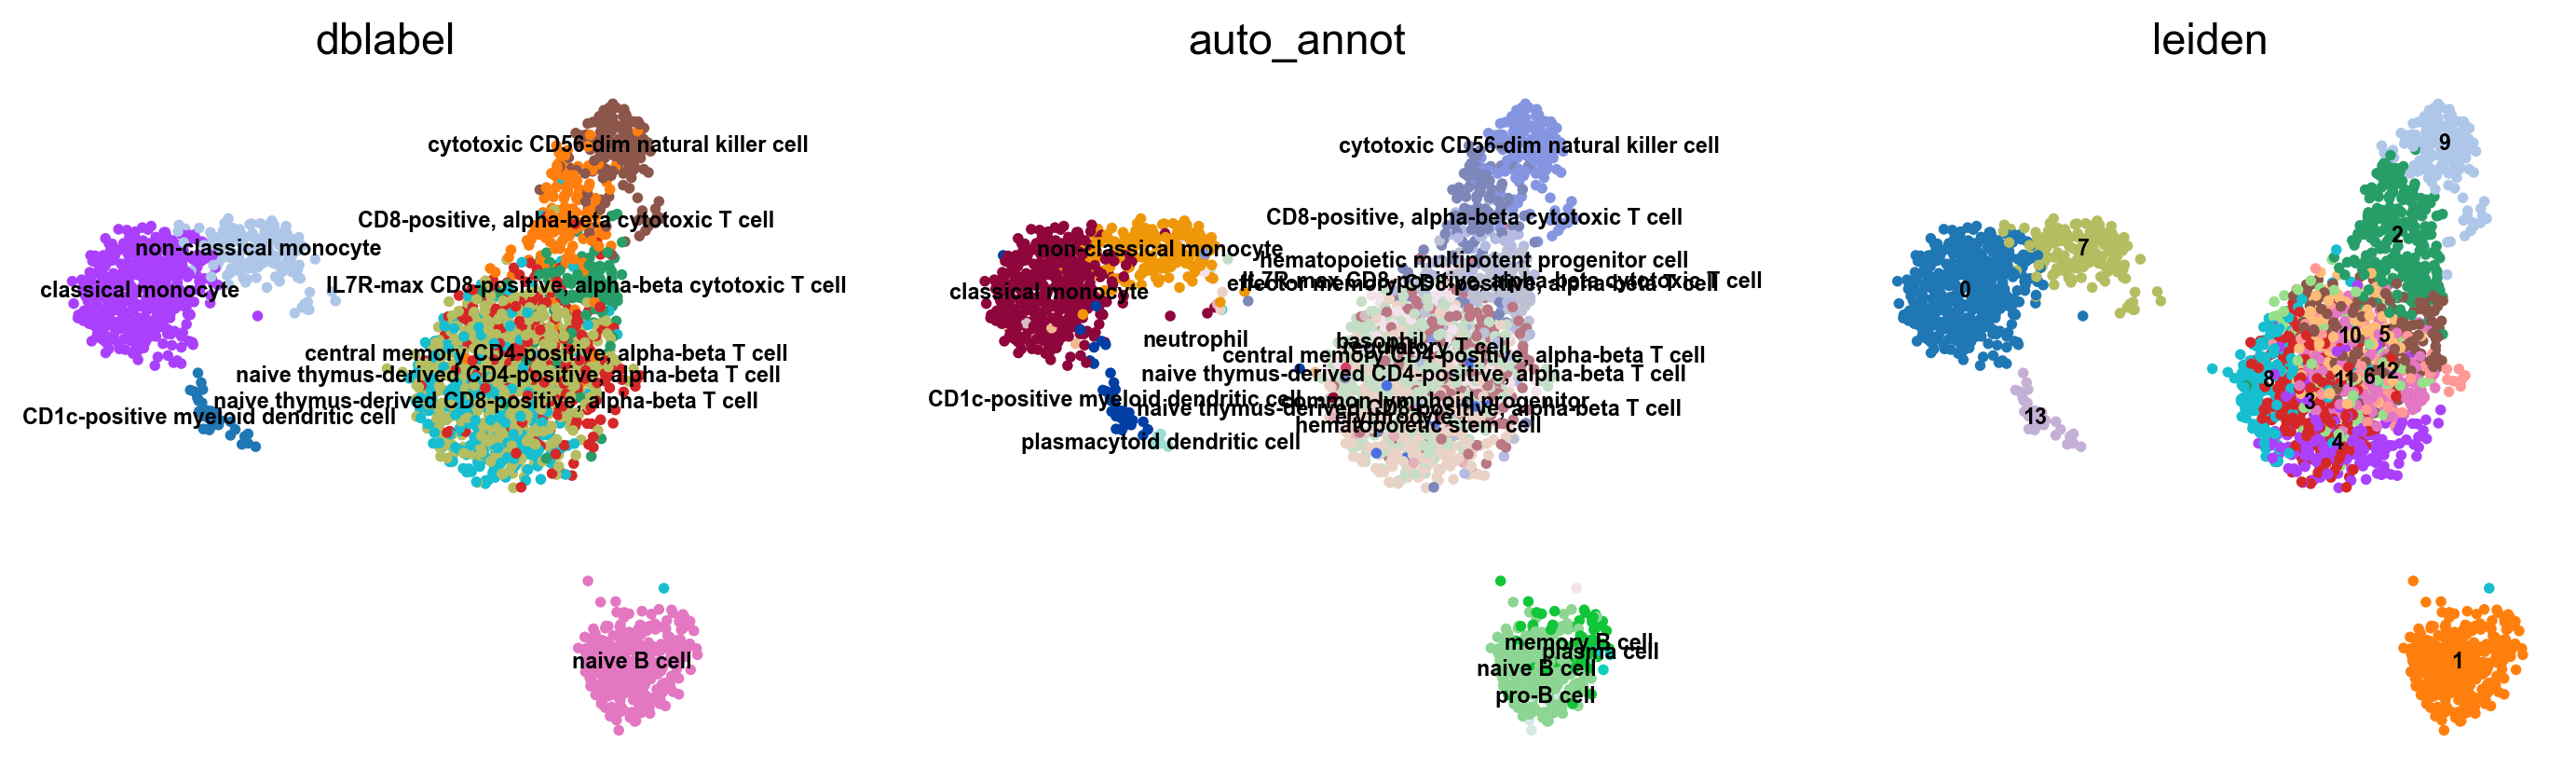

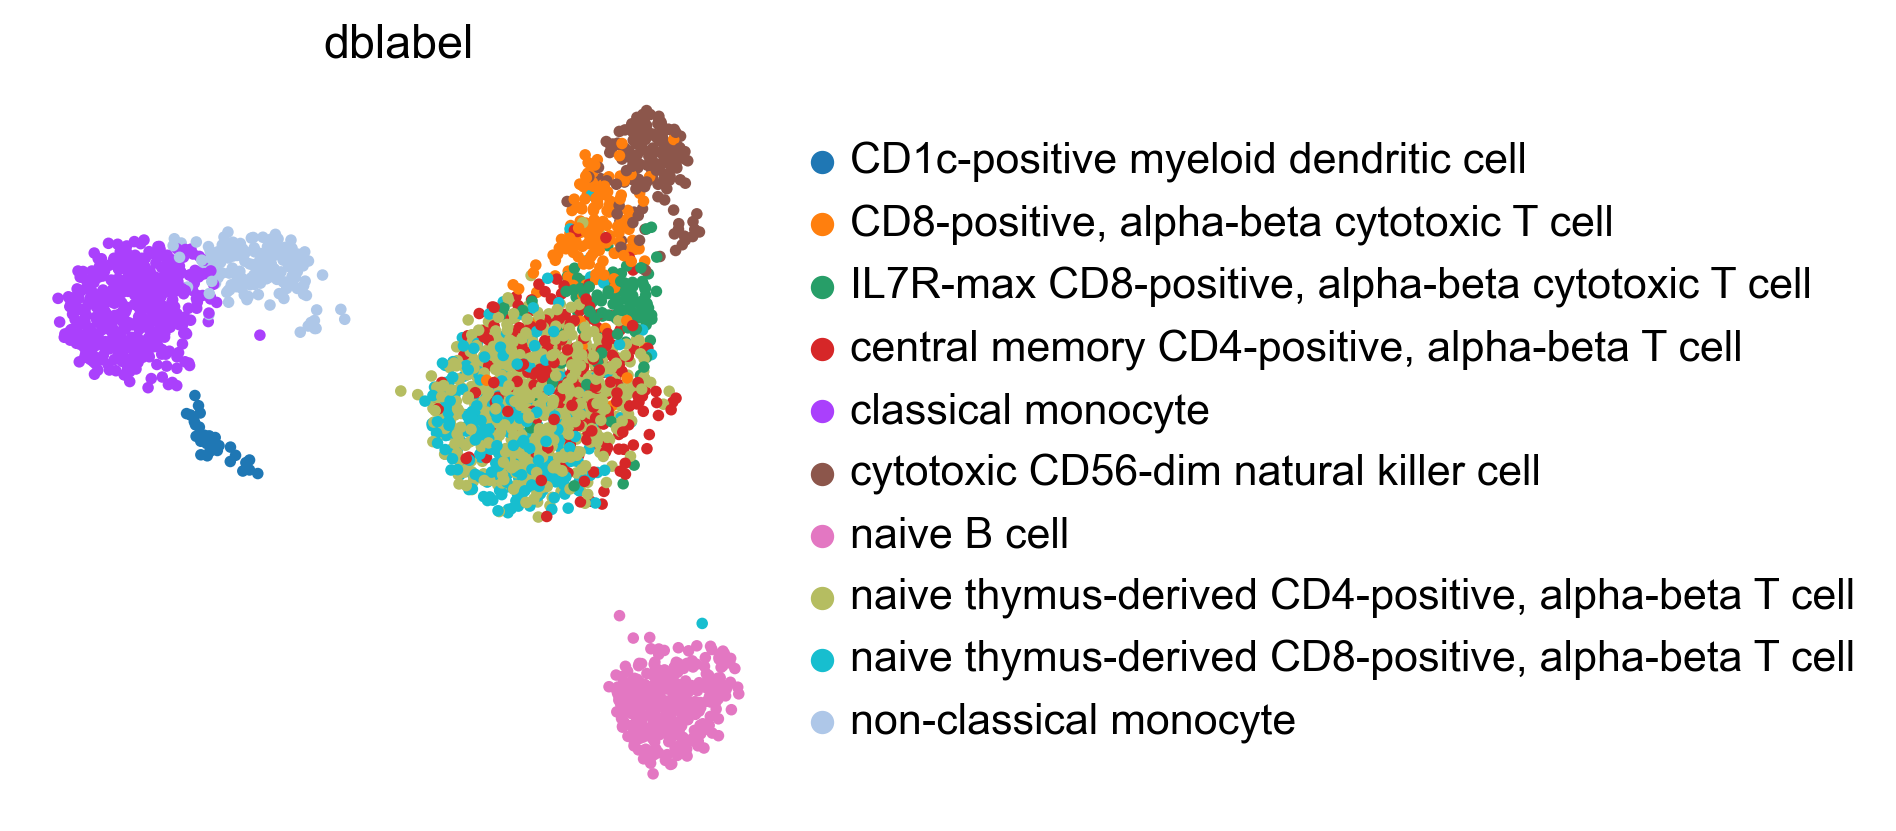

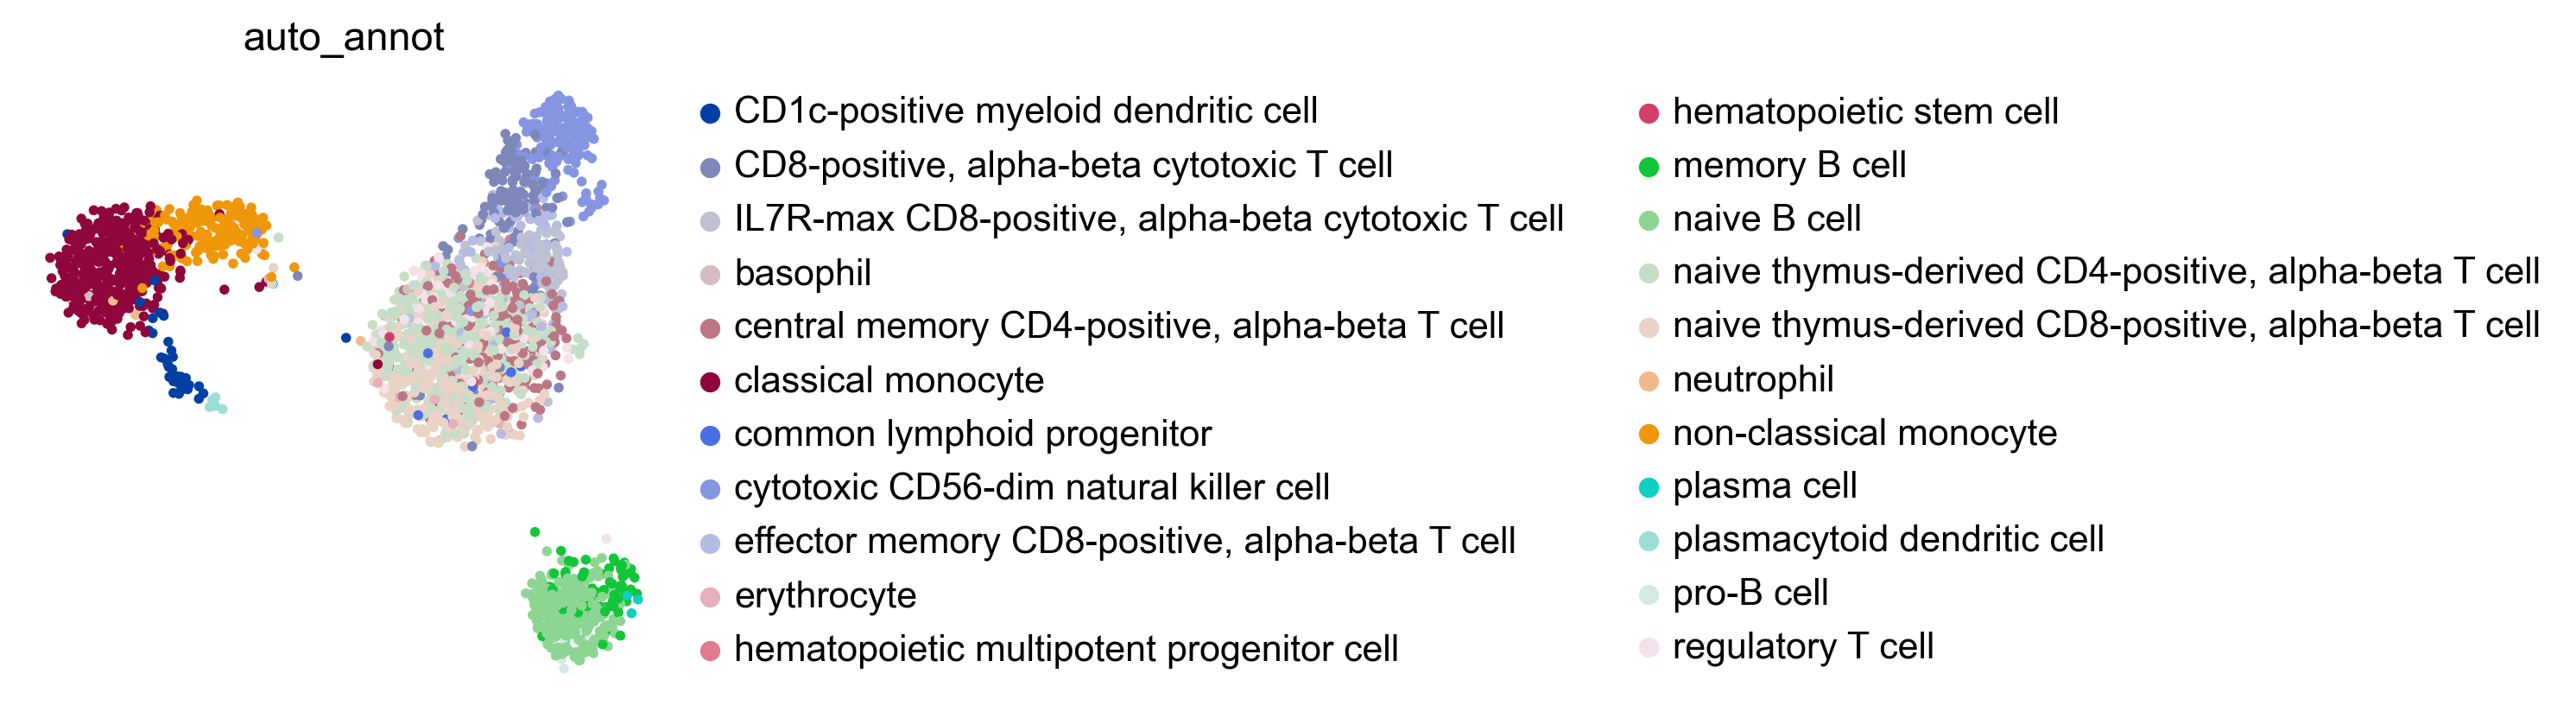

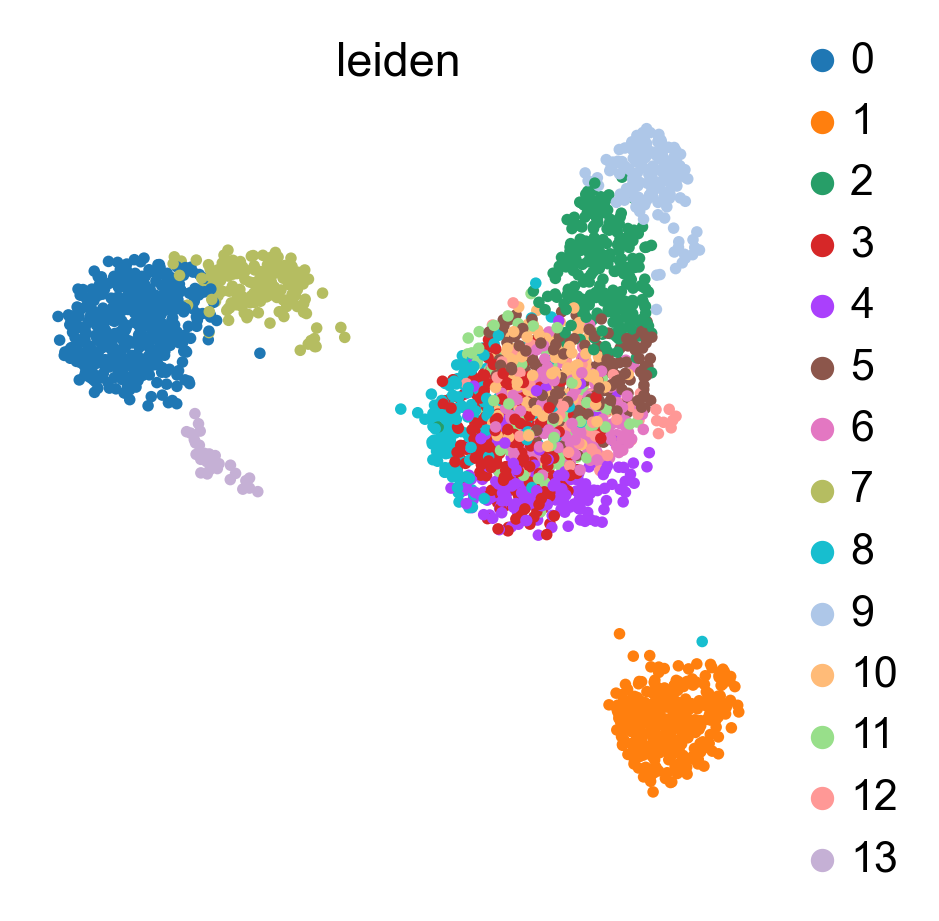

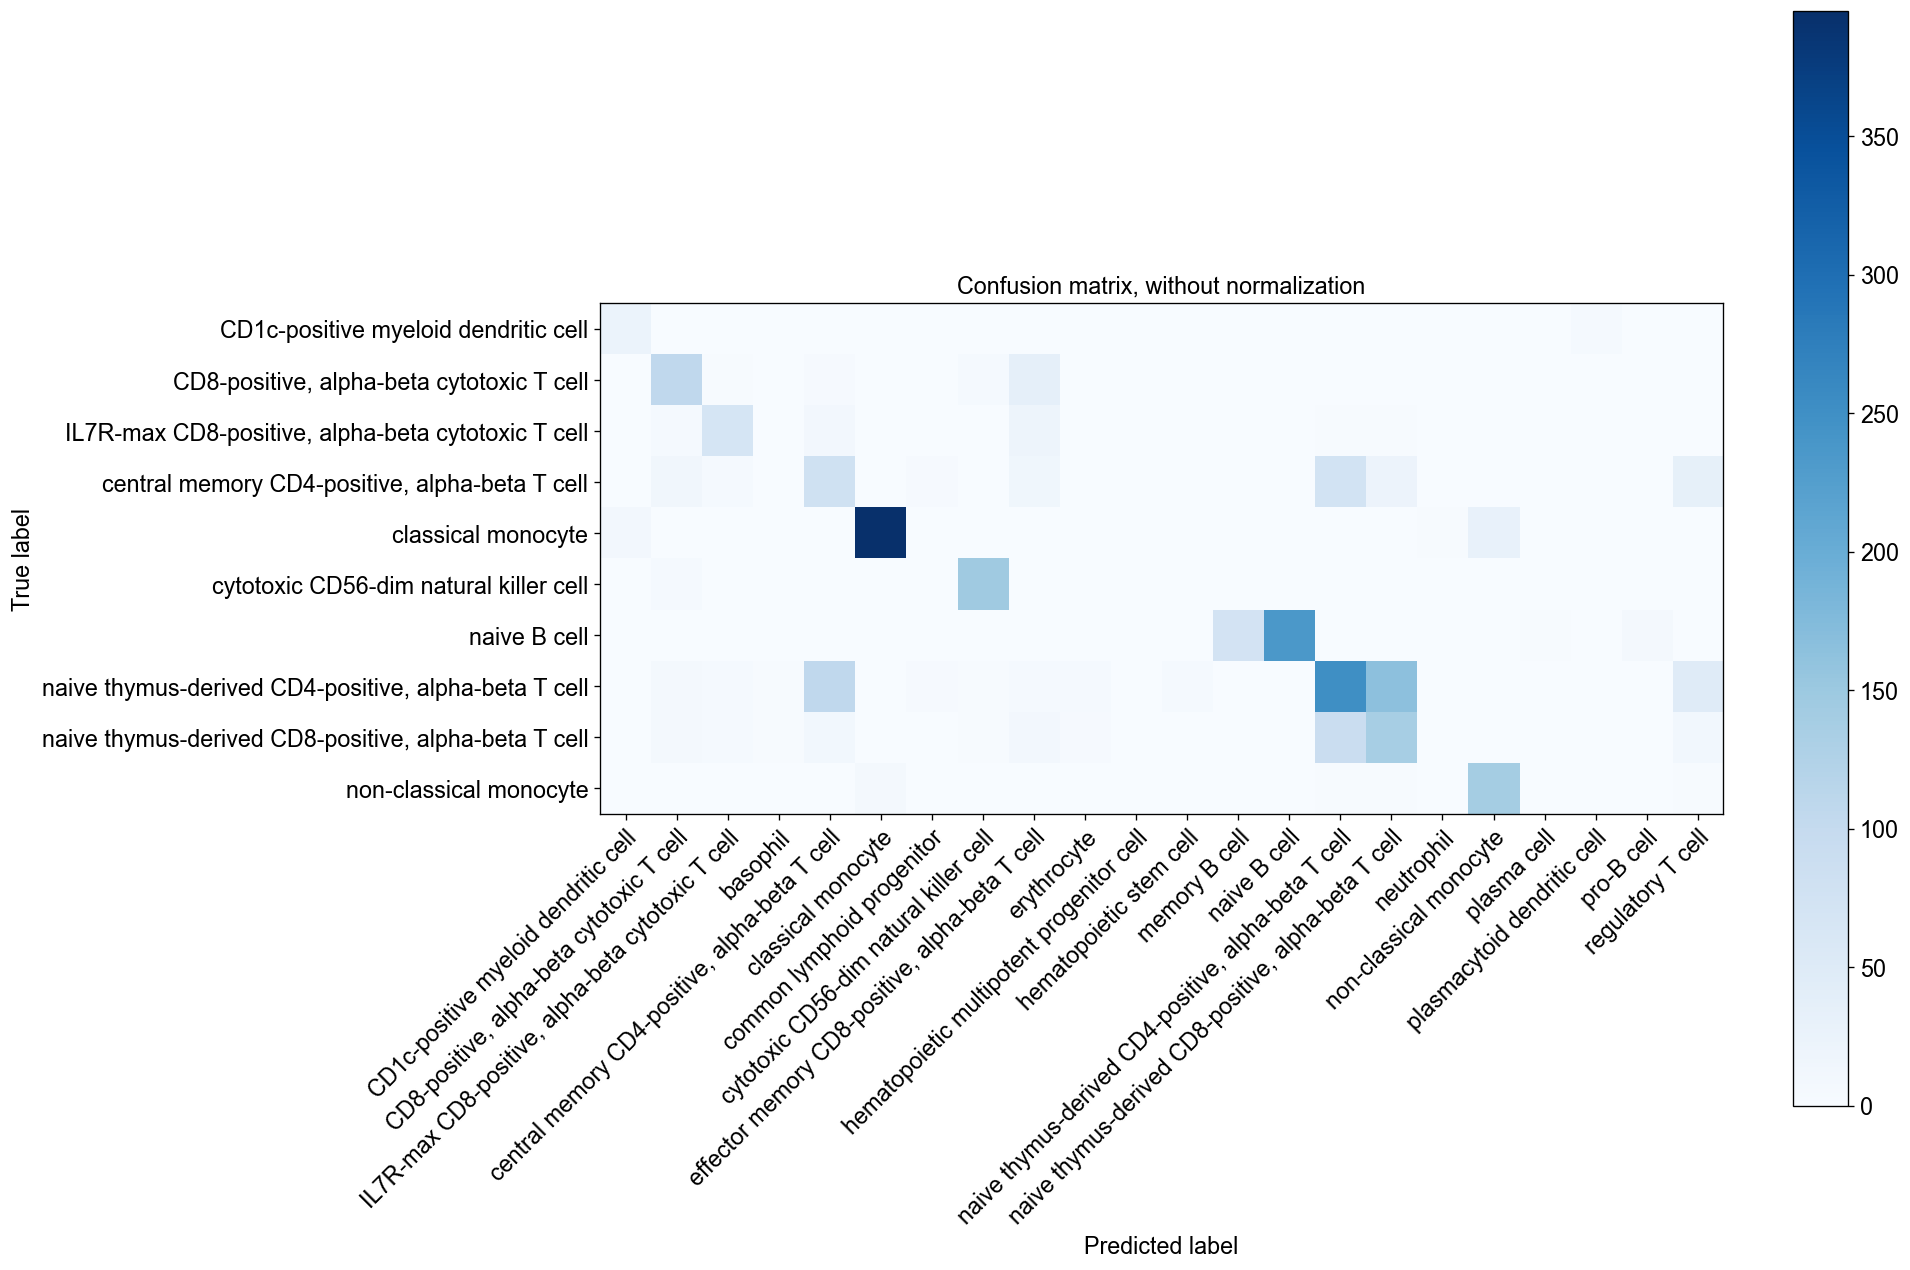

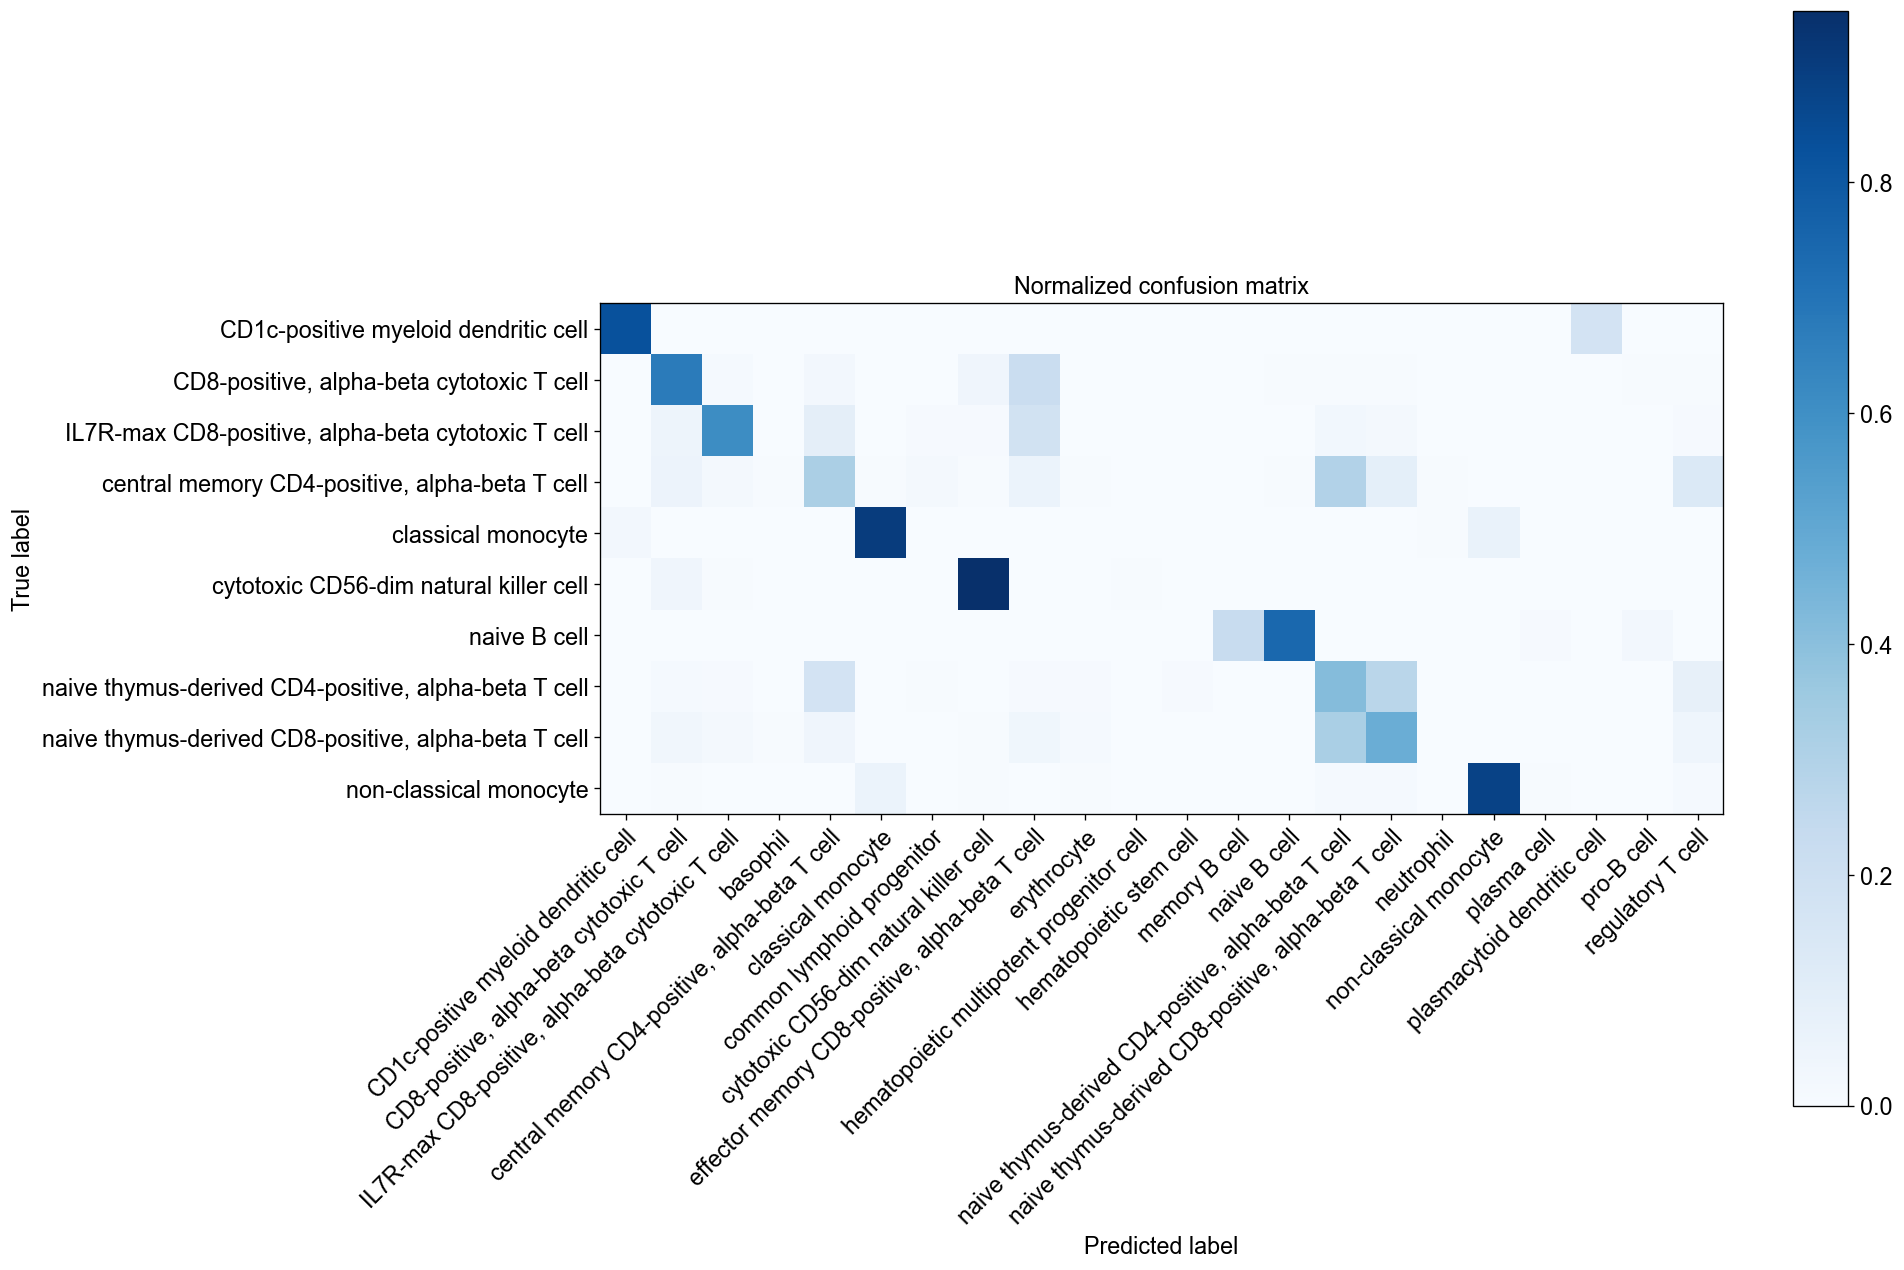

In [20]:
%matplotlib inline
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

If we change our threshold, we can vary the amount of cells labelled as unknown, depending on the confidence required from the predictions. Let's try 0.7


In [21]:
adata_predicted = bc.tl.auto_annot.adata_predict(
    classifier=classifier,
    scaler=scaler,
    adata_pred=adata_test_corrected,
    adata_orig=adata_test_orig,
    threshold=0.7,
)


We observe that many more cells, where the assignment is not unambiguous are now labelled as unknown.


besca.tl.auto_annot.report(...) is deprecated( besca > 2.3); please use besca.tl.report(...)


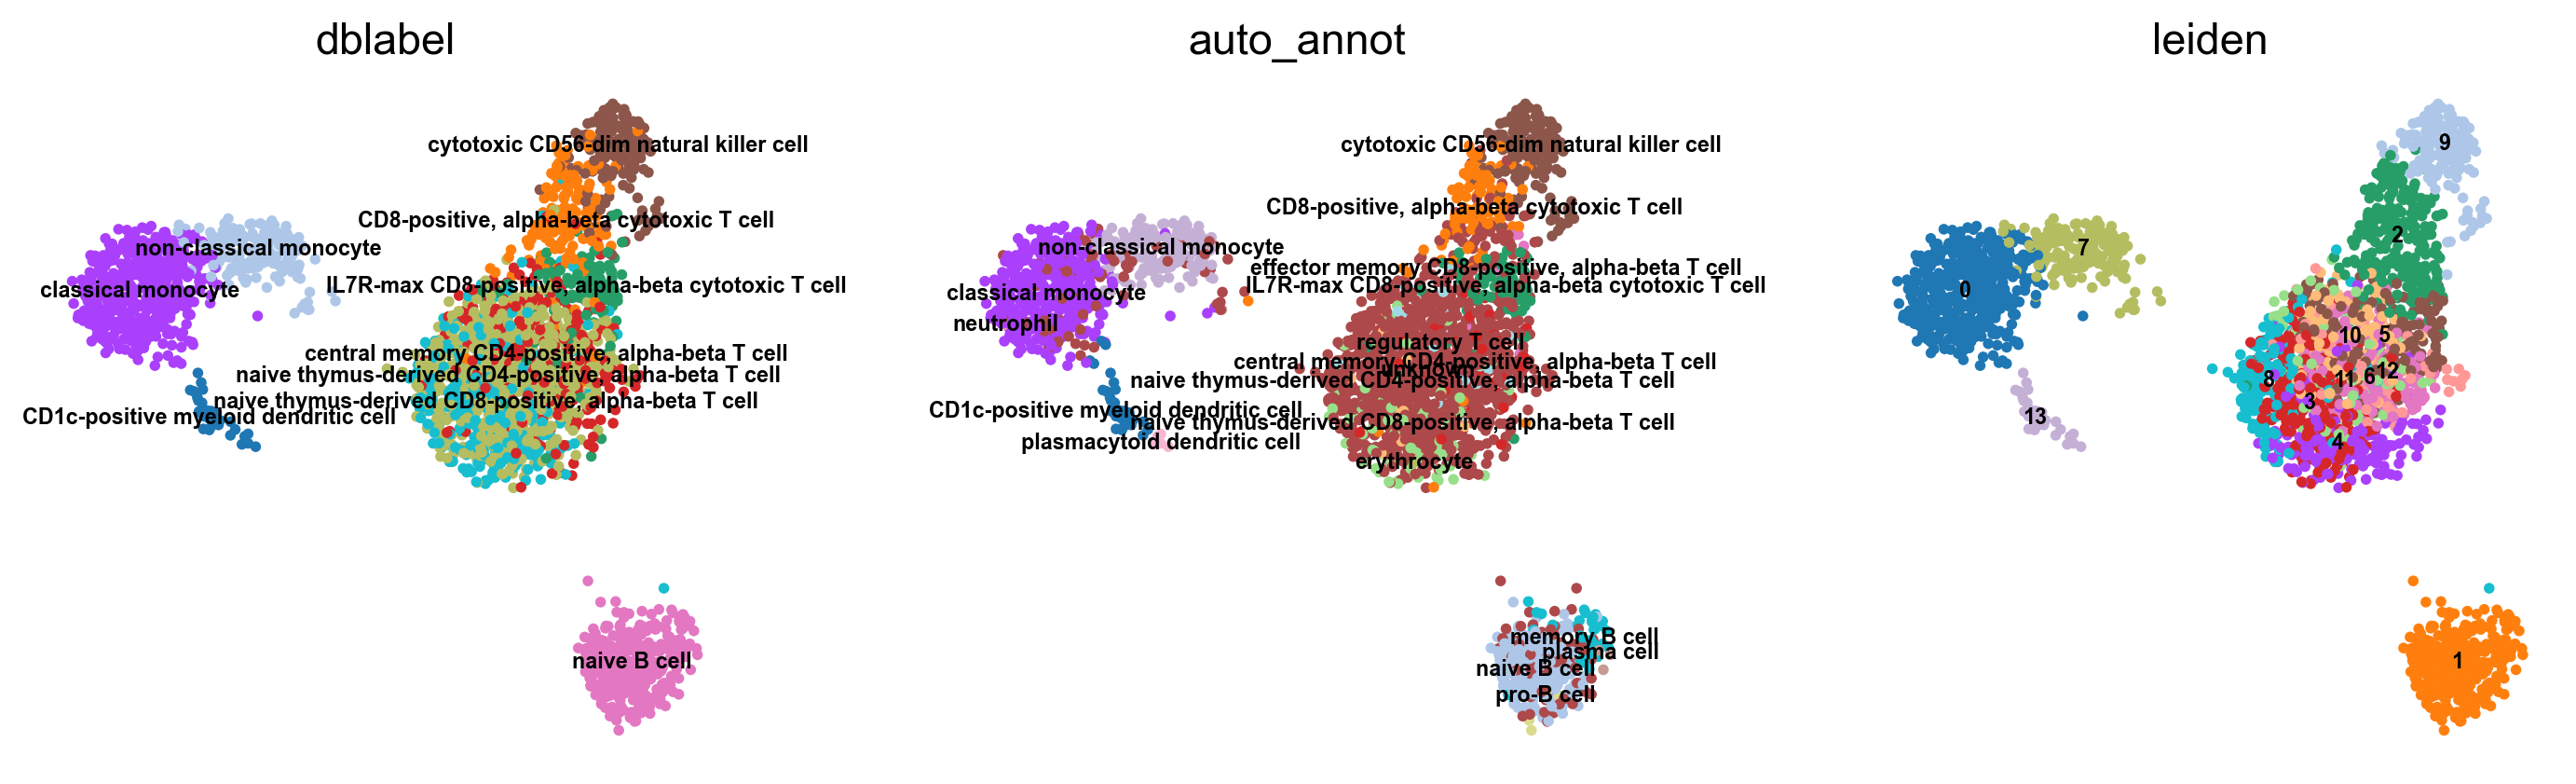

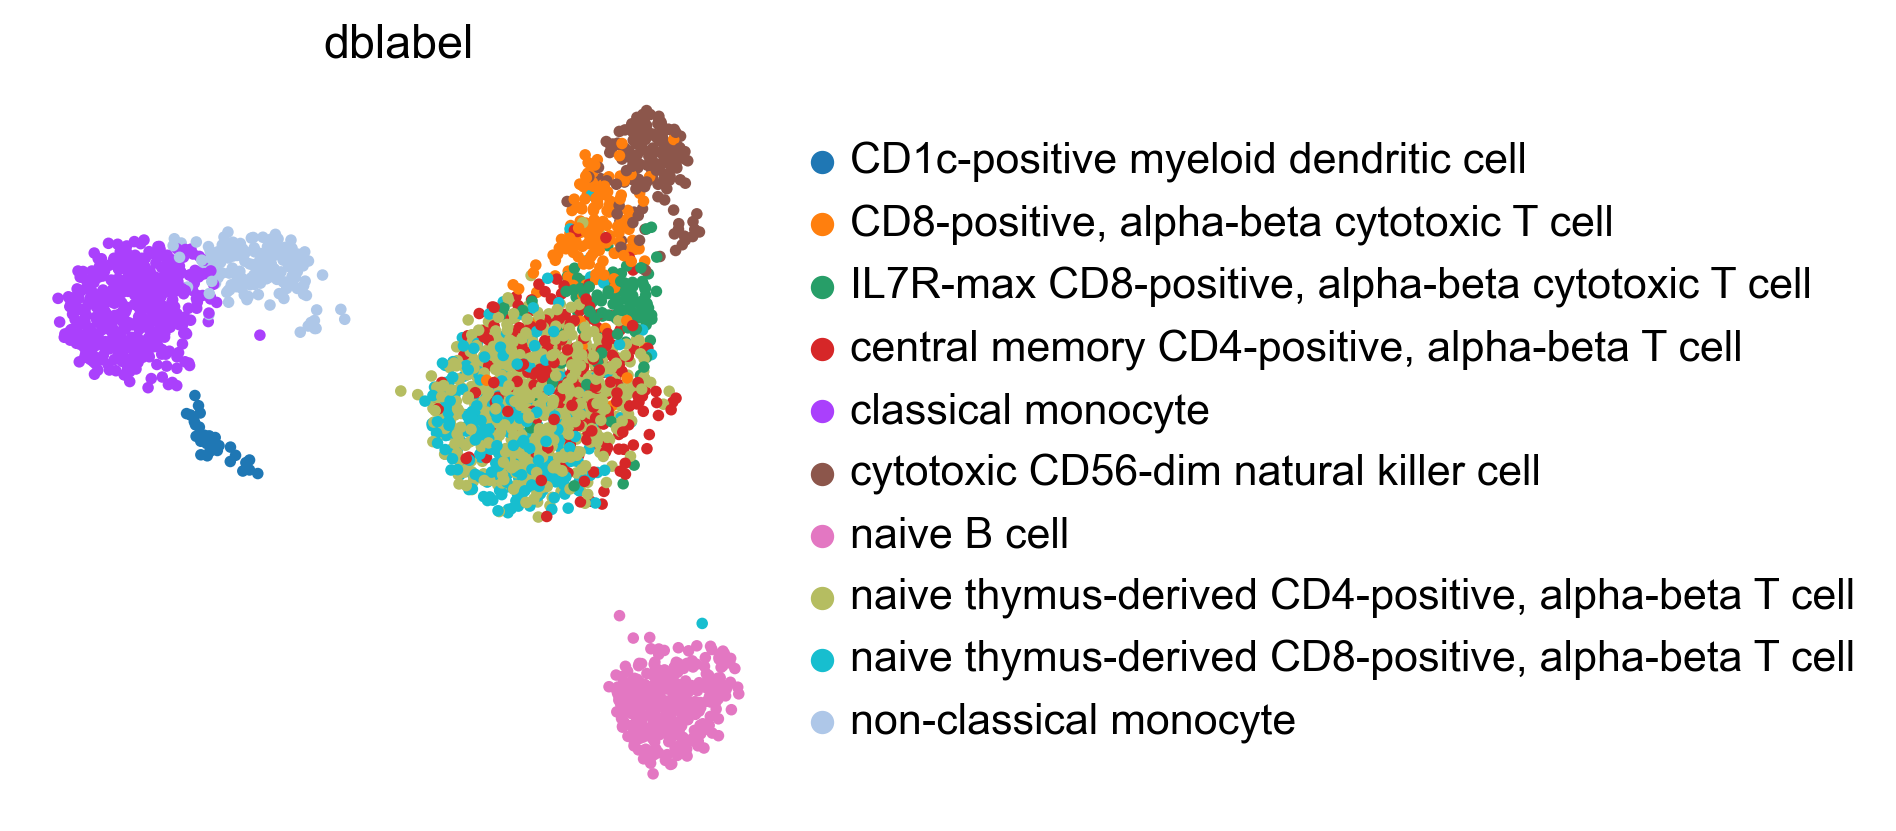

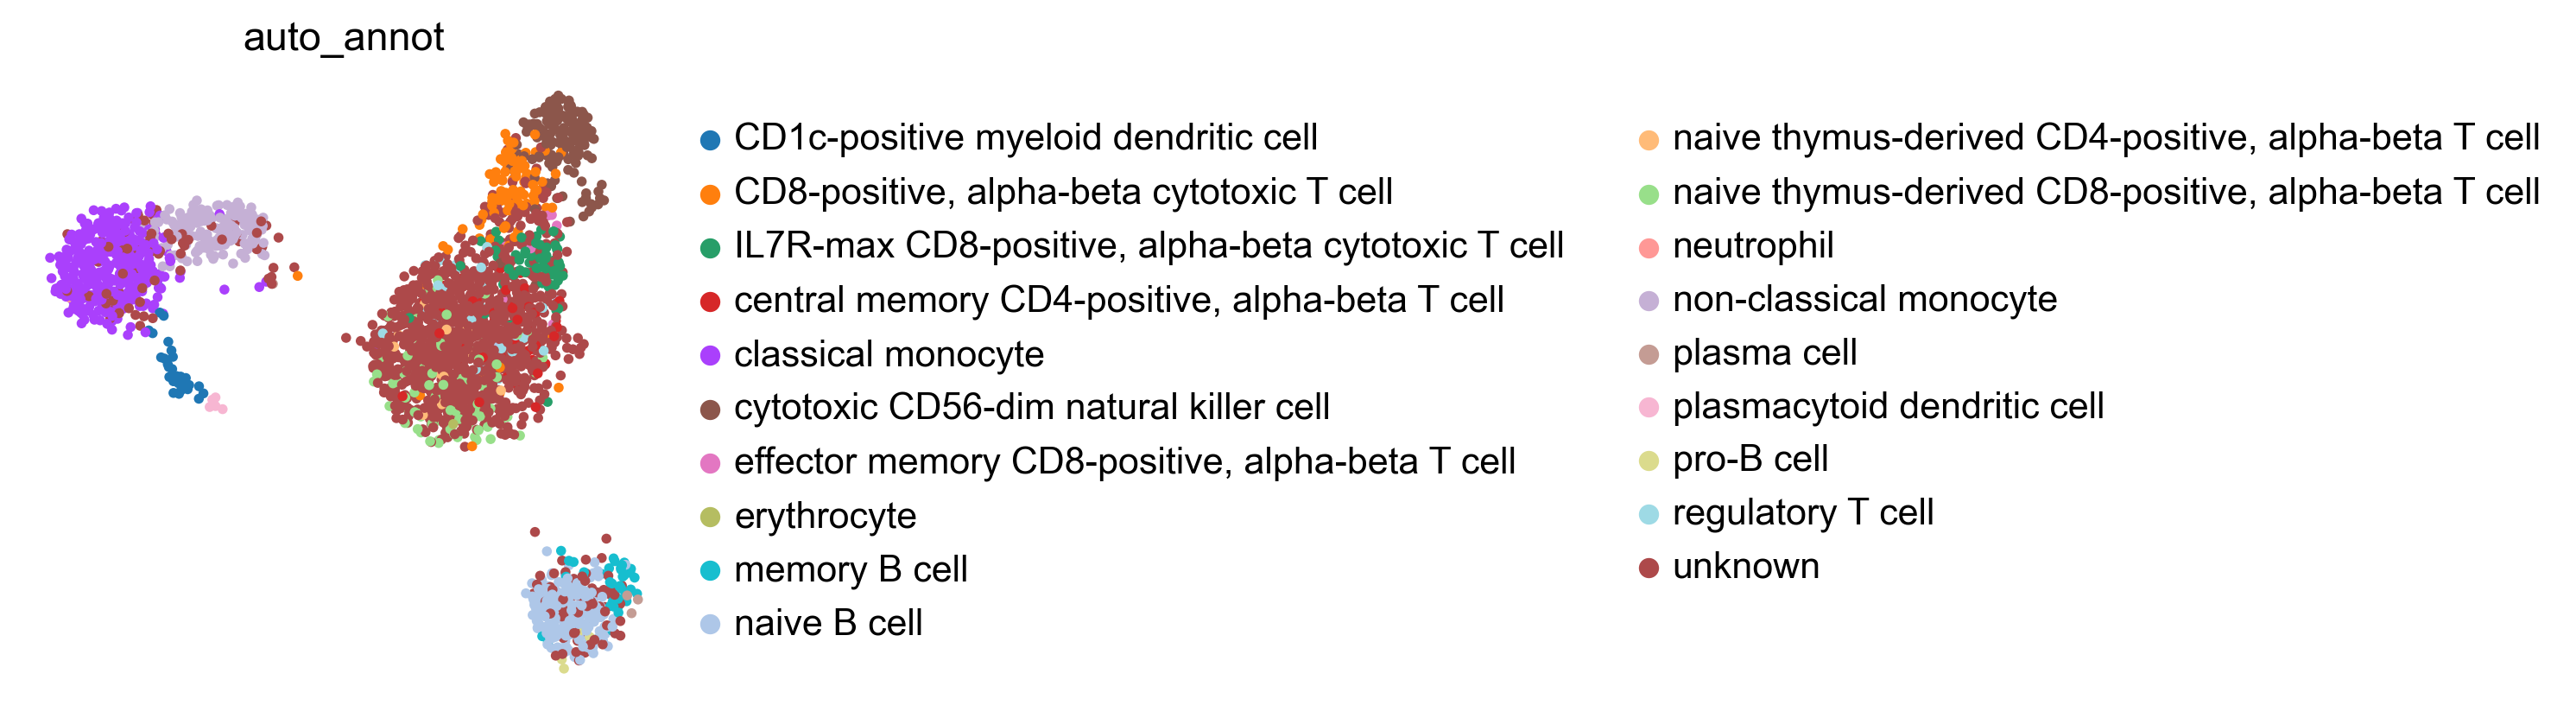

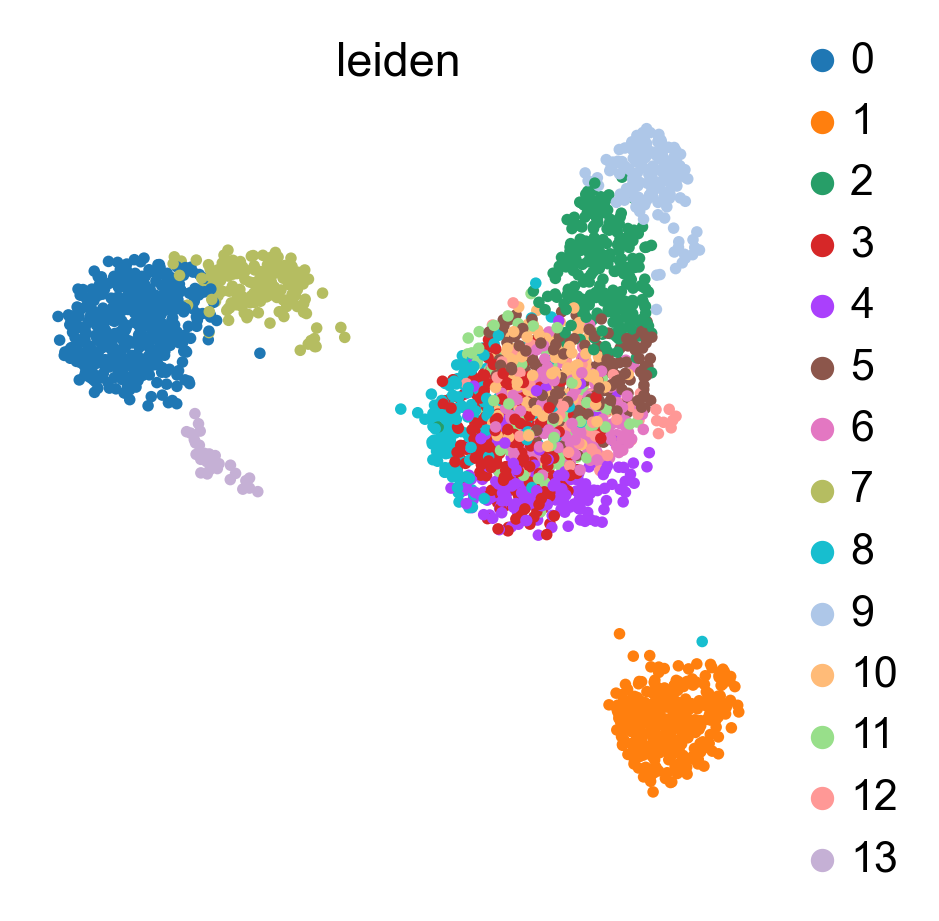

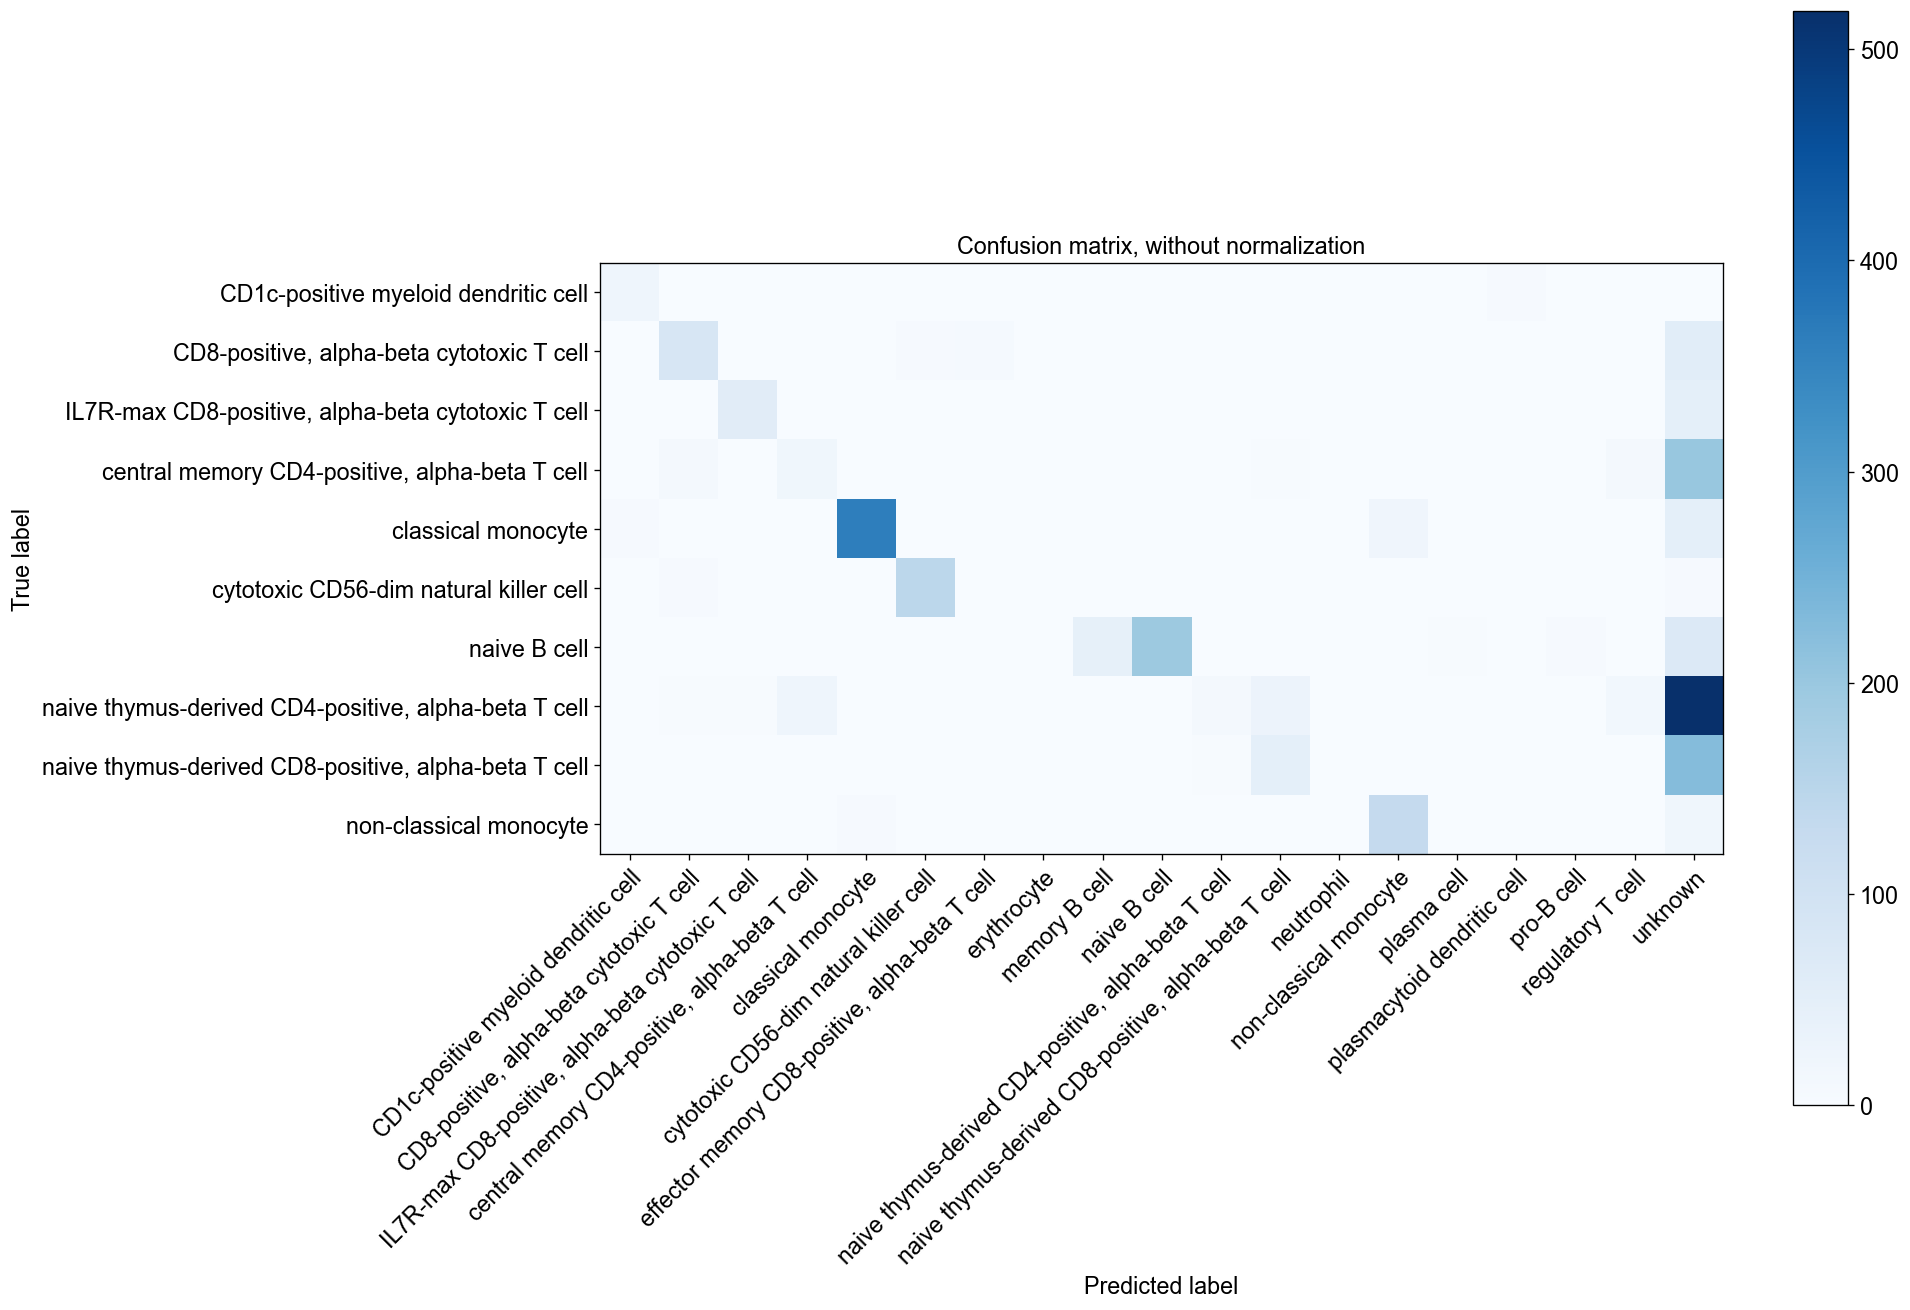

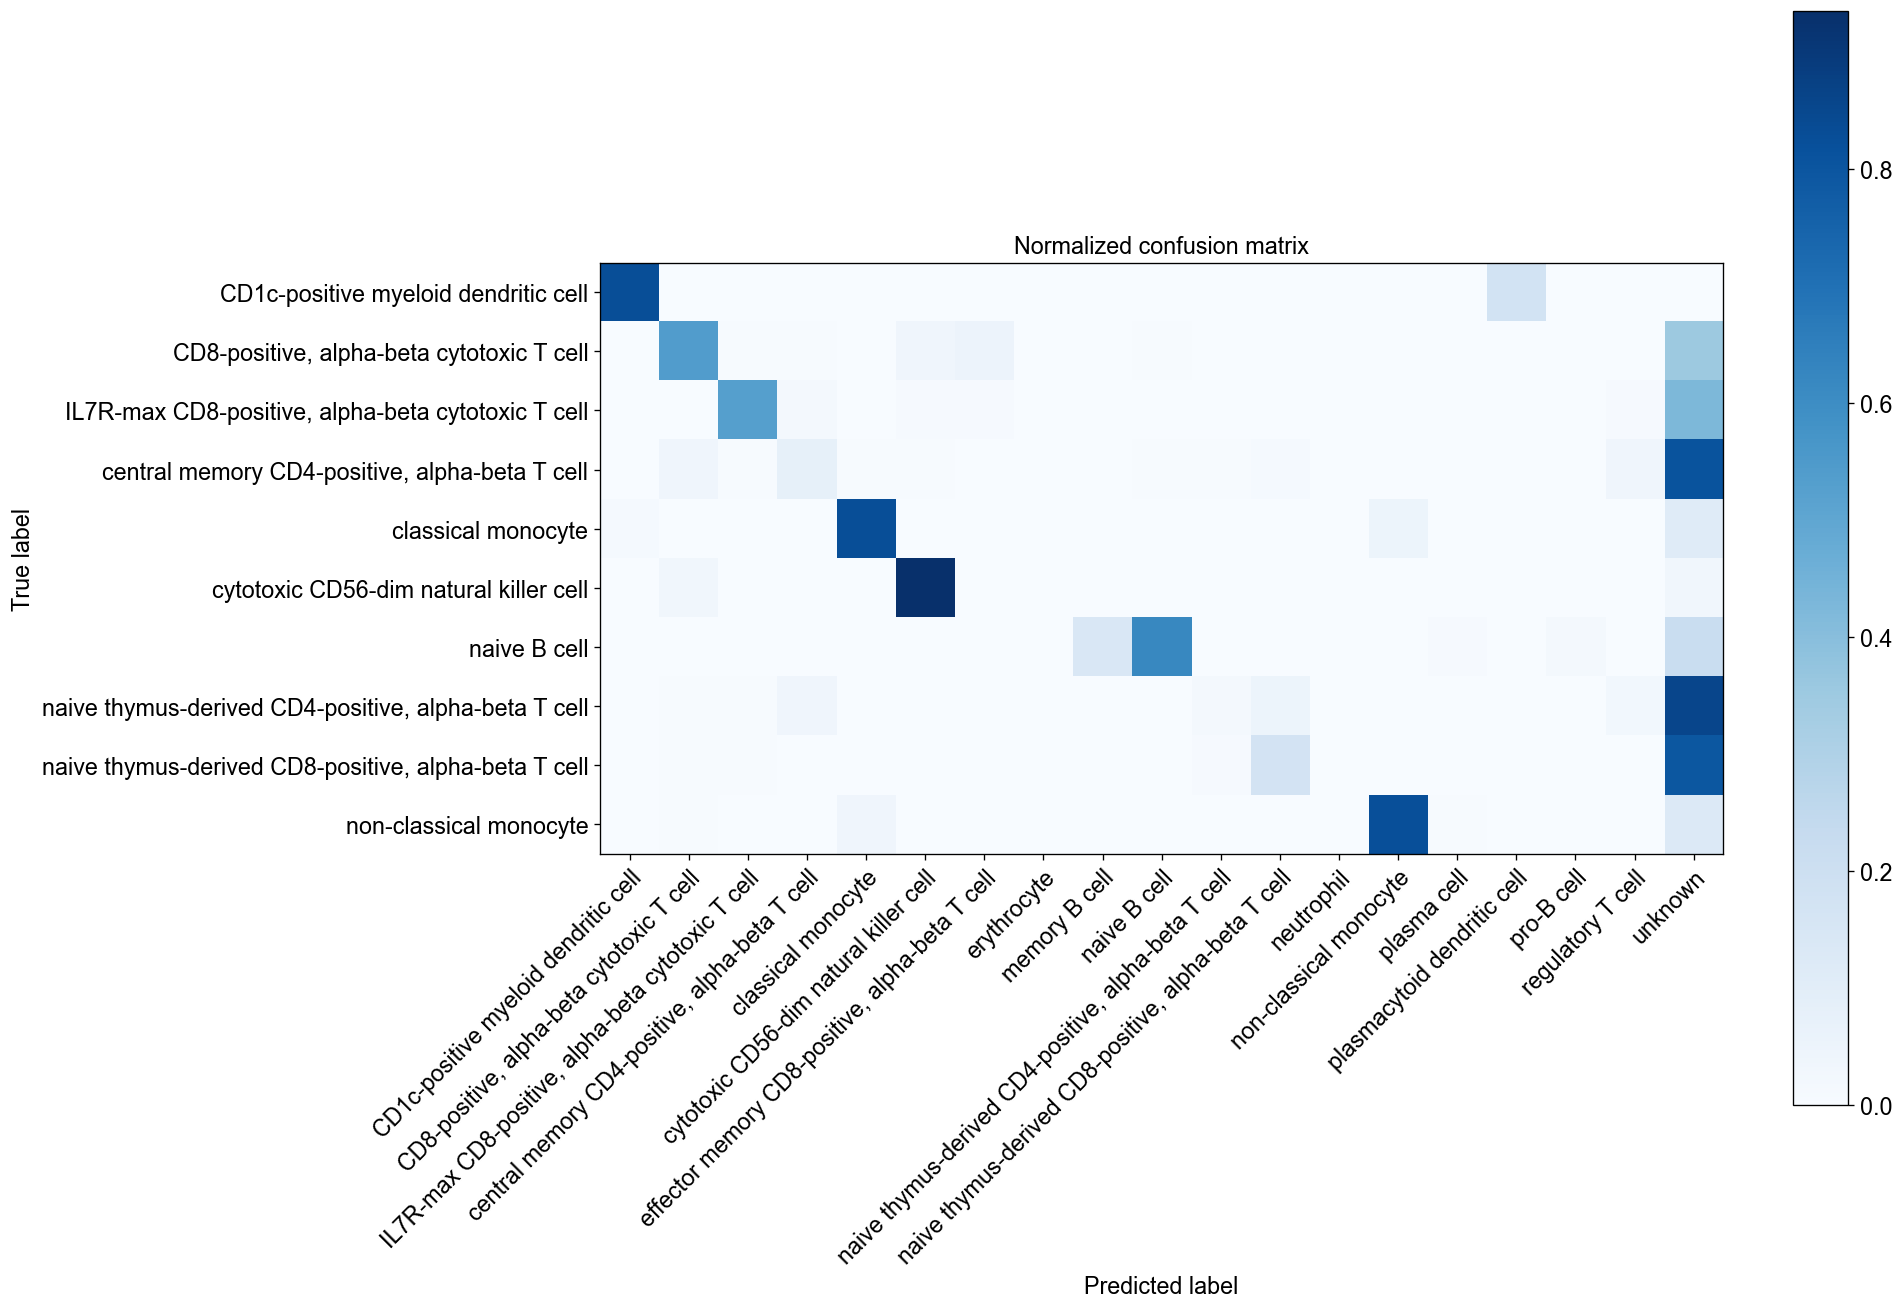

In [22]:
%matplotlib inline
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

## Let's try another classifier (SVM)


Especially when thresholds are not used, SVMs can be tried as alternative classifiers.


In [23]:
analysis_name = "auto_annot_tutorial_svm"
celltype = "dblabel"  # column name of celltype of interest
method = "linear"  # rbf or linear or sgd, rbf extremely slow cannot recommend, logistic_regression recommended, as you can get probabilities, random_forest is a fast but not very powerful option (in current implementation)
merge = "scanorama"
use_raw = False
genes_to_use = "all"


In [24]:
adata_test = adata_test_orig.copy()


In [25]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(
    adata_train_list, adata_test, genes_to_use=genes_to_use, merge=merge
)


merging with scanorama
using scanorama rn
Found 207 genes among all datasets
[[0.   0.7  0.48]
 [0.   0.   0.99]
 [0.   0.   0.  ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


In [26]:
classifier, scaler = bc.tl.auto_annot.fit(
    adata_train=adata_train, method=method, celltype=celltype, njobs=14
)


In [27]:
adata_predicted = bc.tl.auto_annot.adata_predict(
    classifier=classifier,
    scaler=scaler,
    adata_pred=adata_test_corrected,
    adata_orig=adata_test_orig,
)


In [28]:
adata_predicted.write("/tmp/adata_predicted_svm.h5ad")


besca.tl.auto_annot.report(...) is deprecated( besca > 2.3); please use besca.tl.report(...)


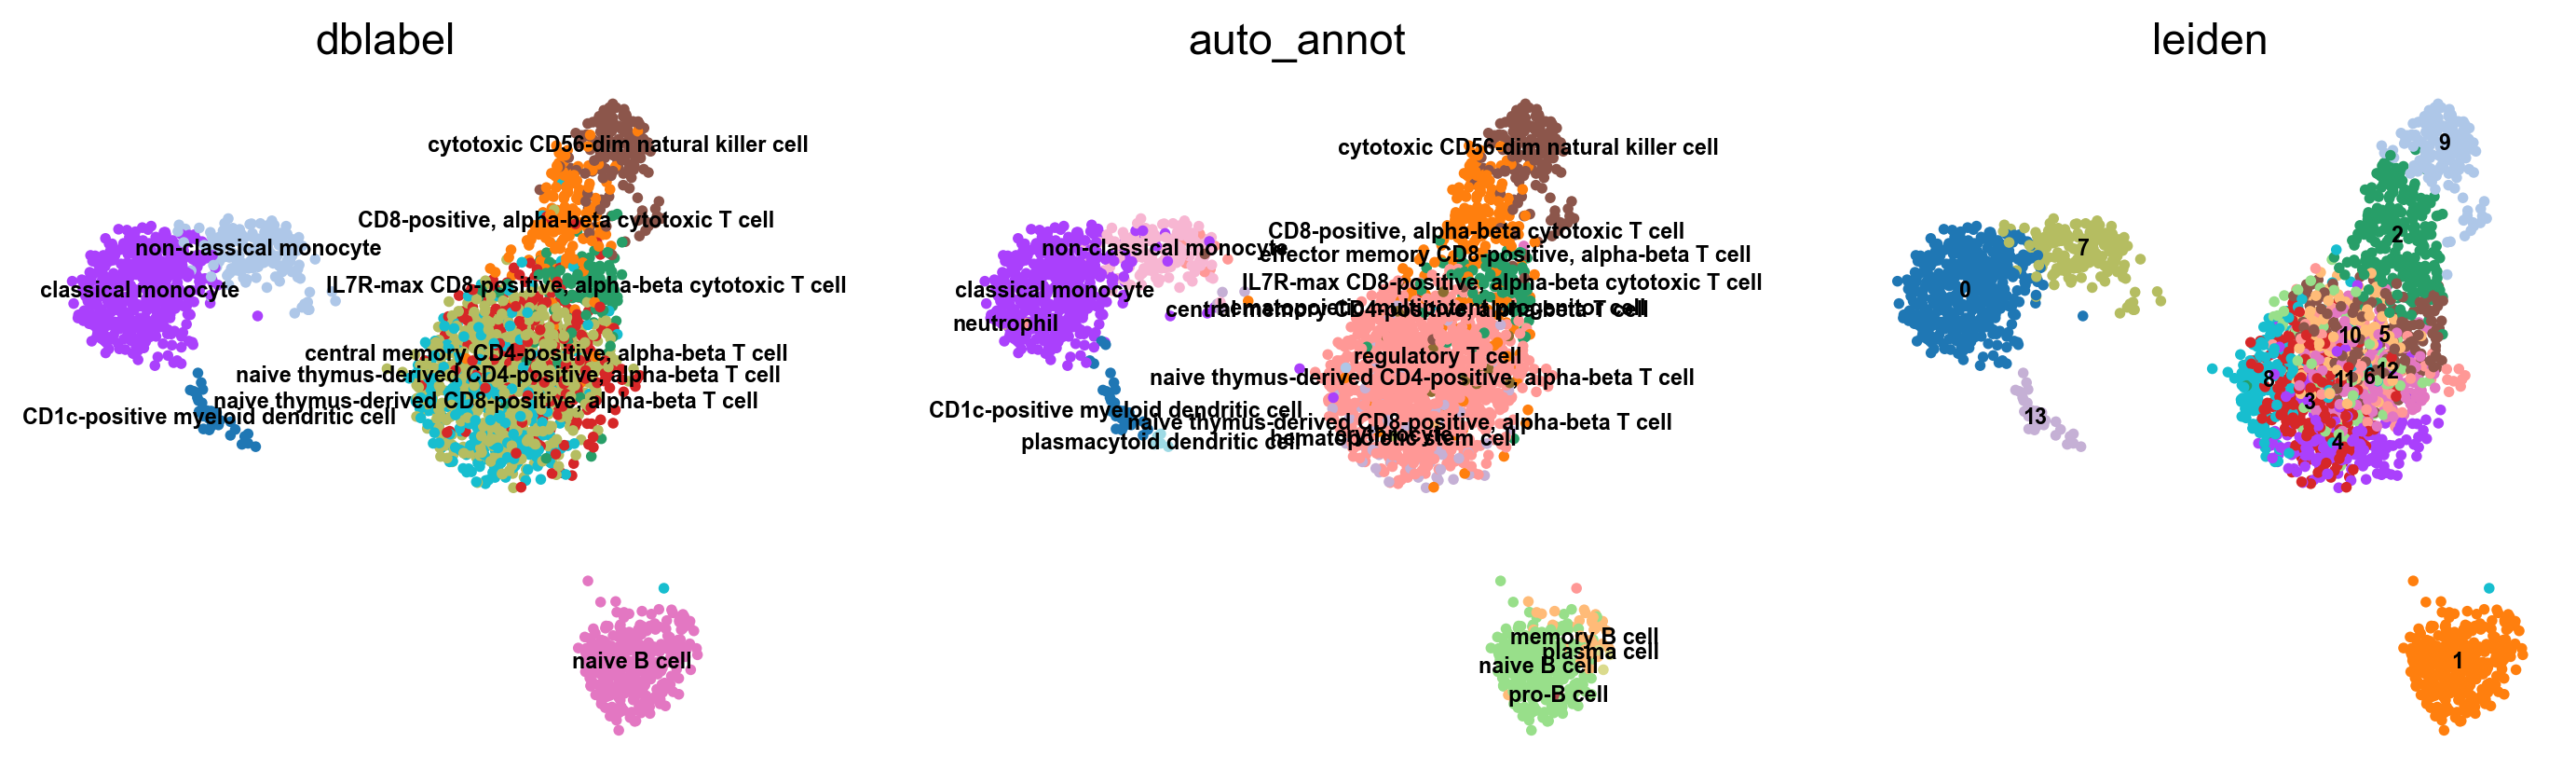

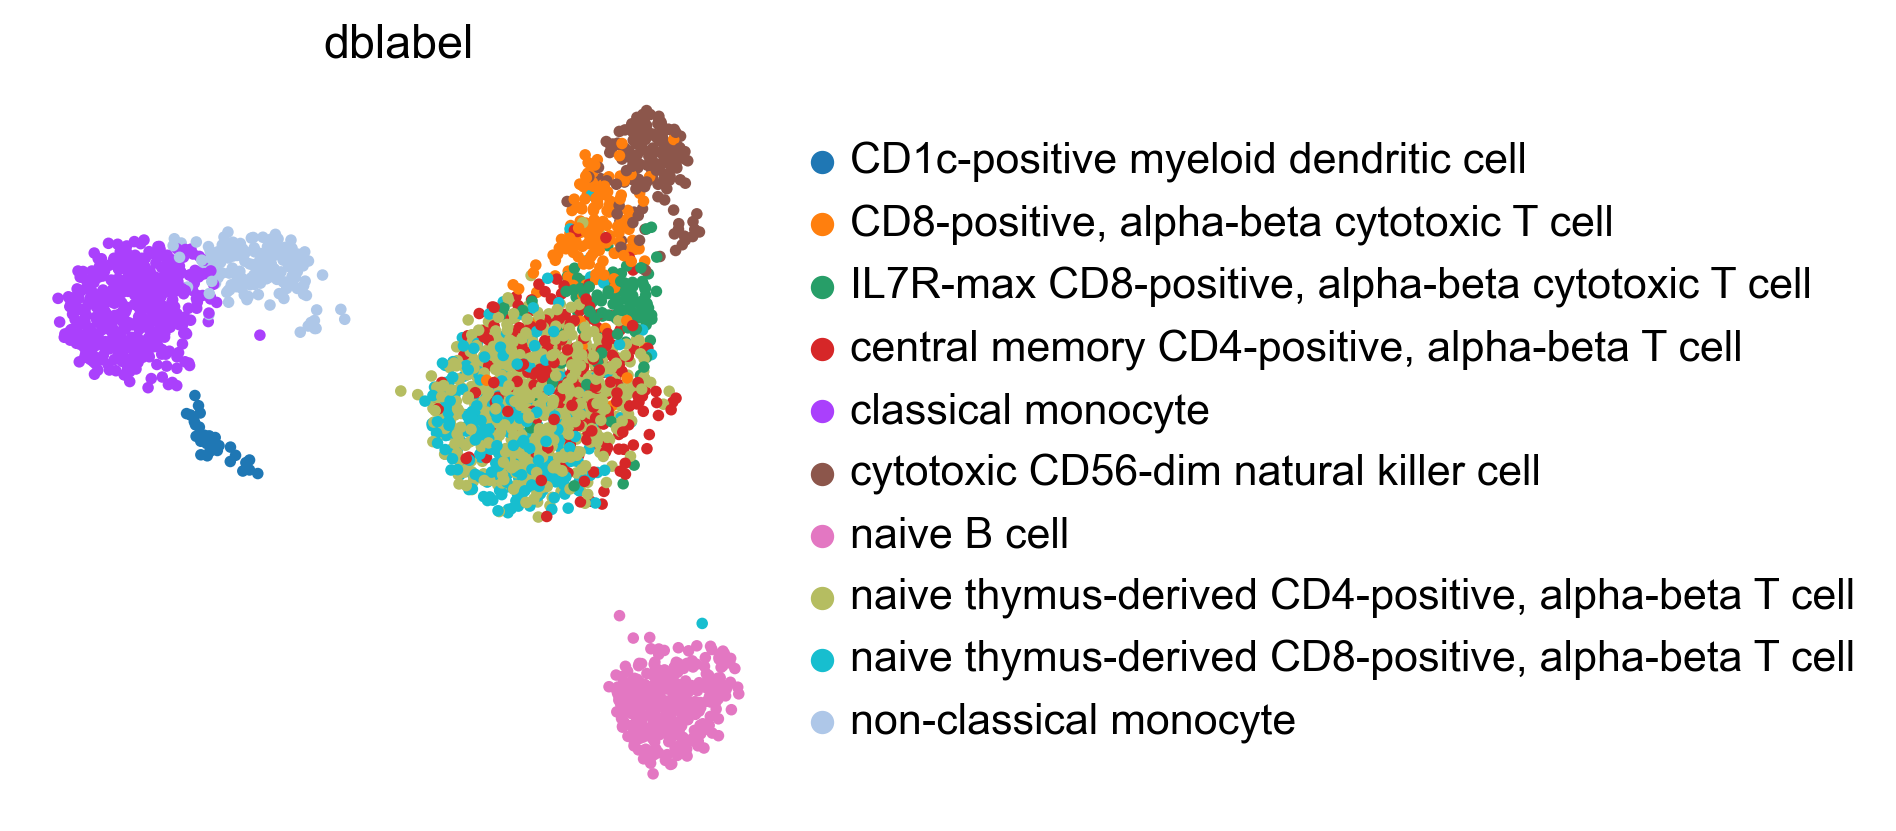

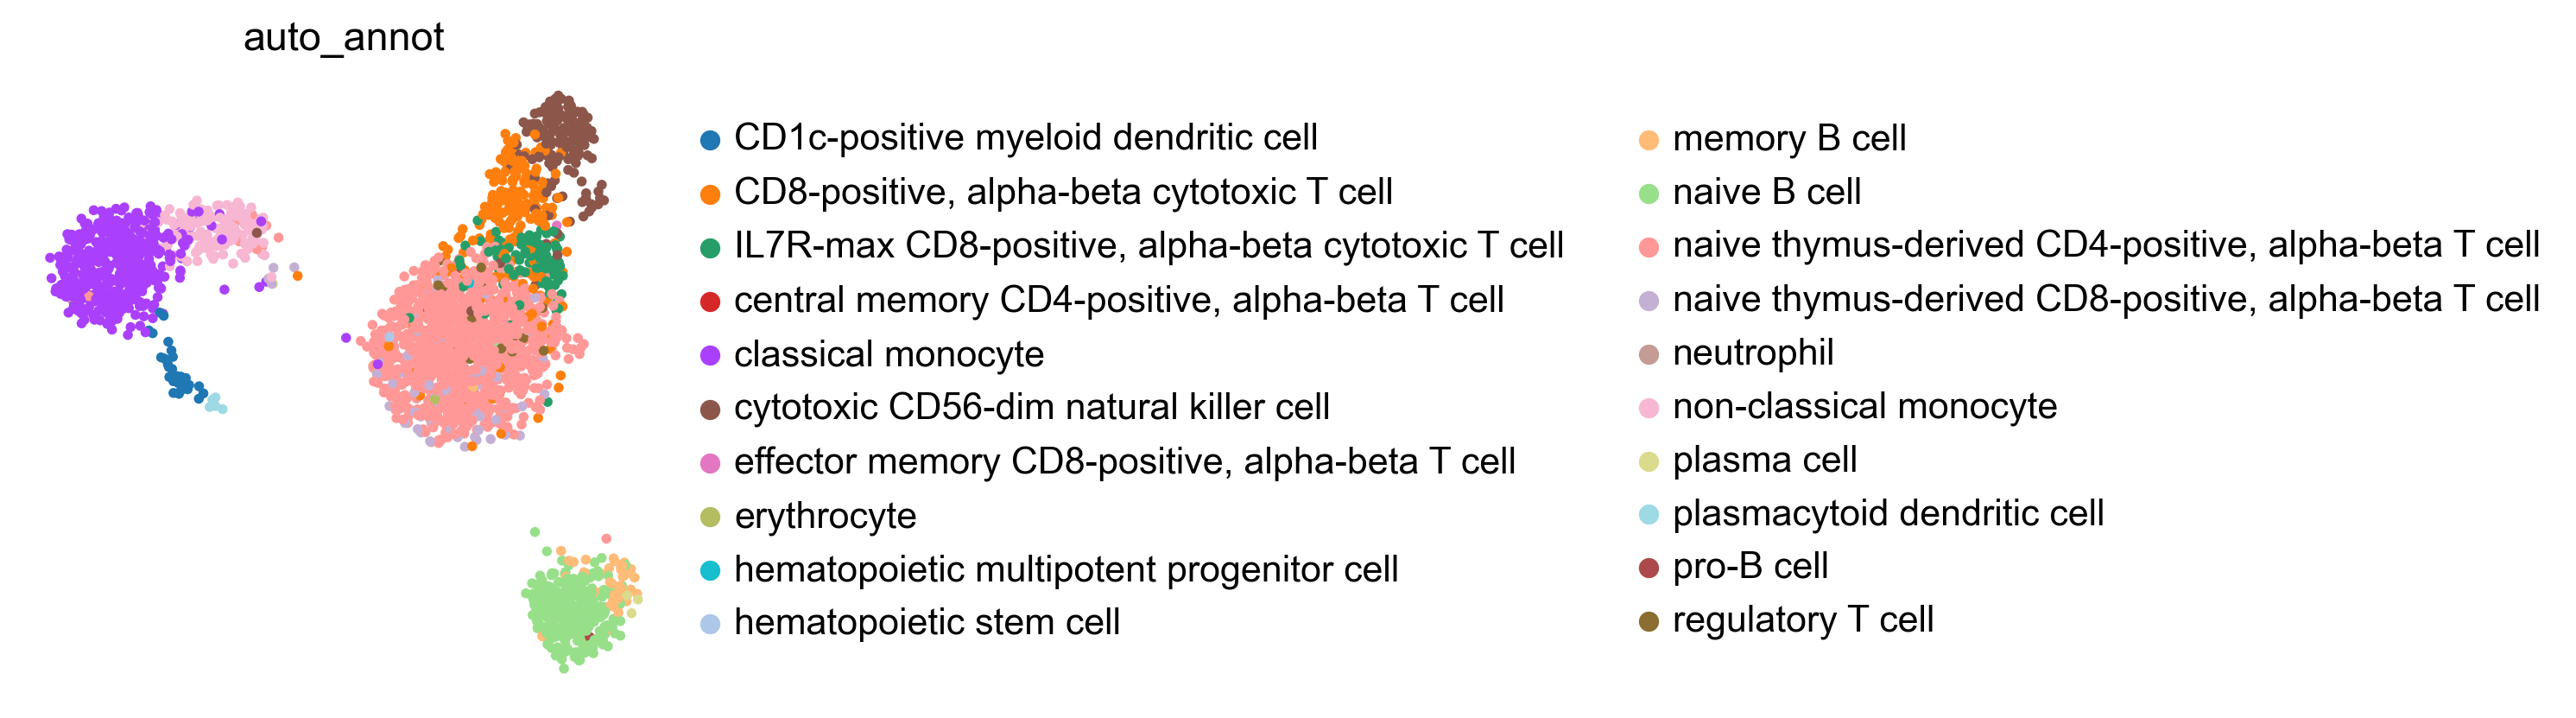

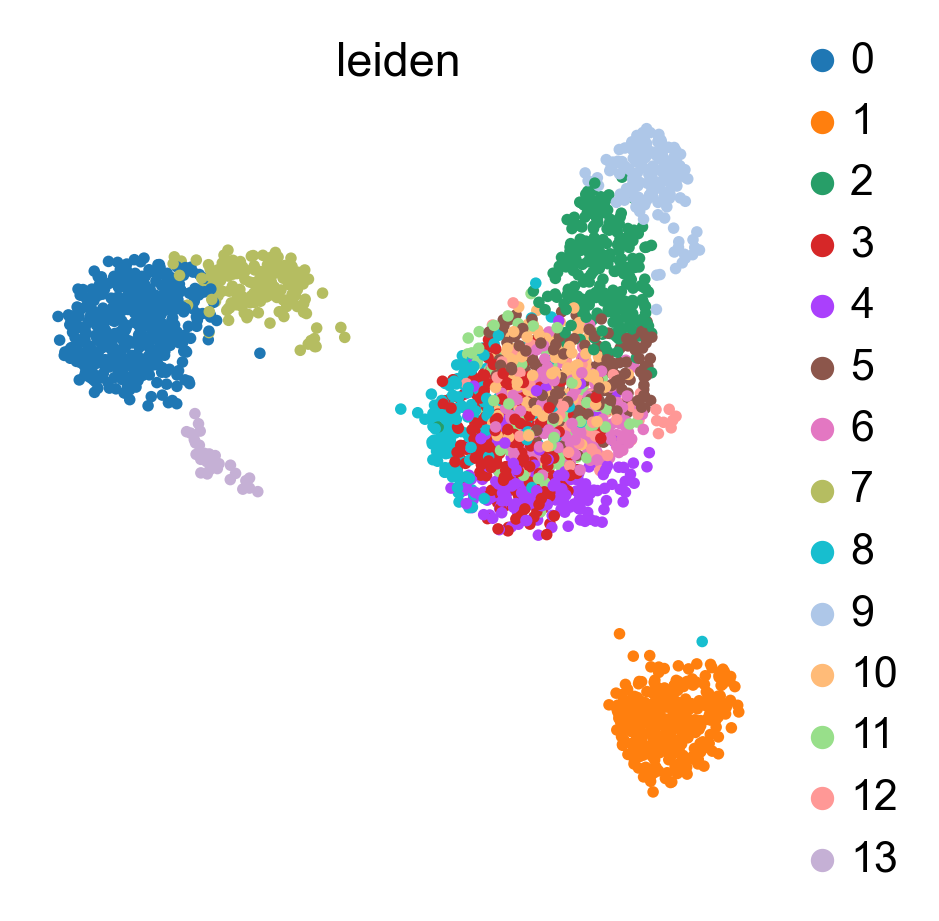

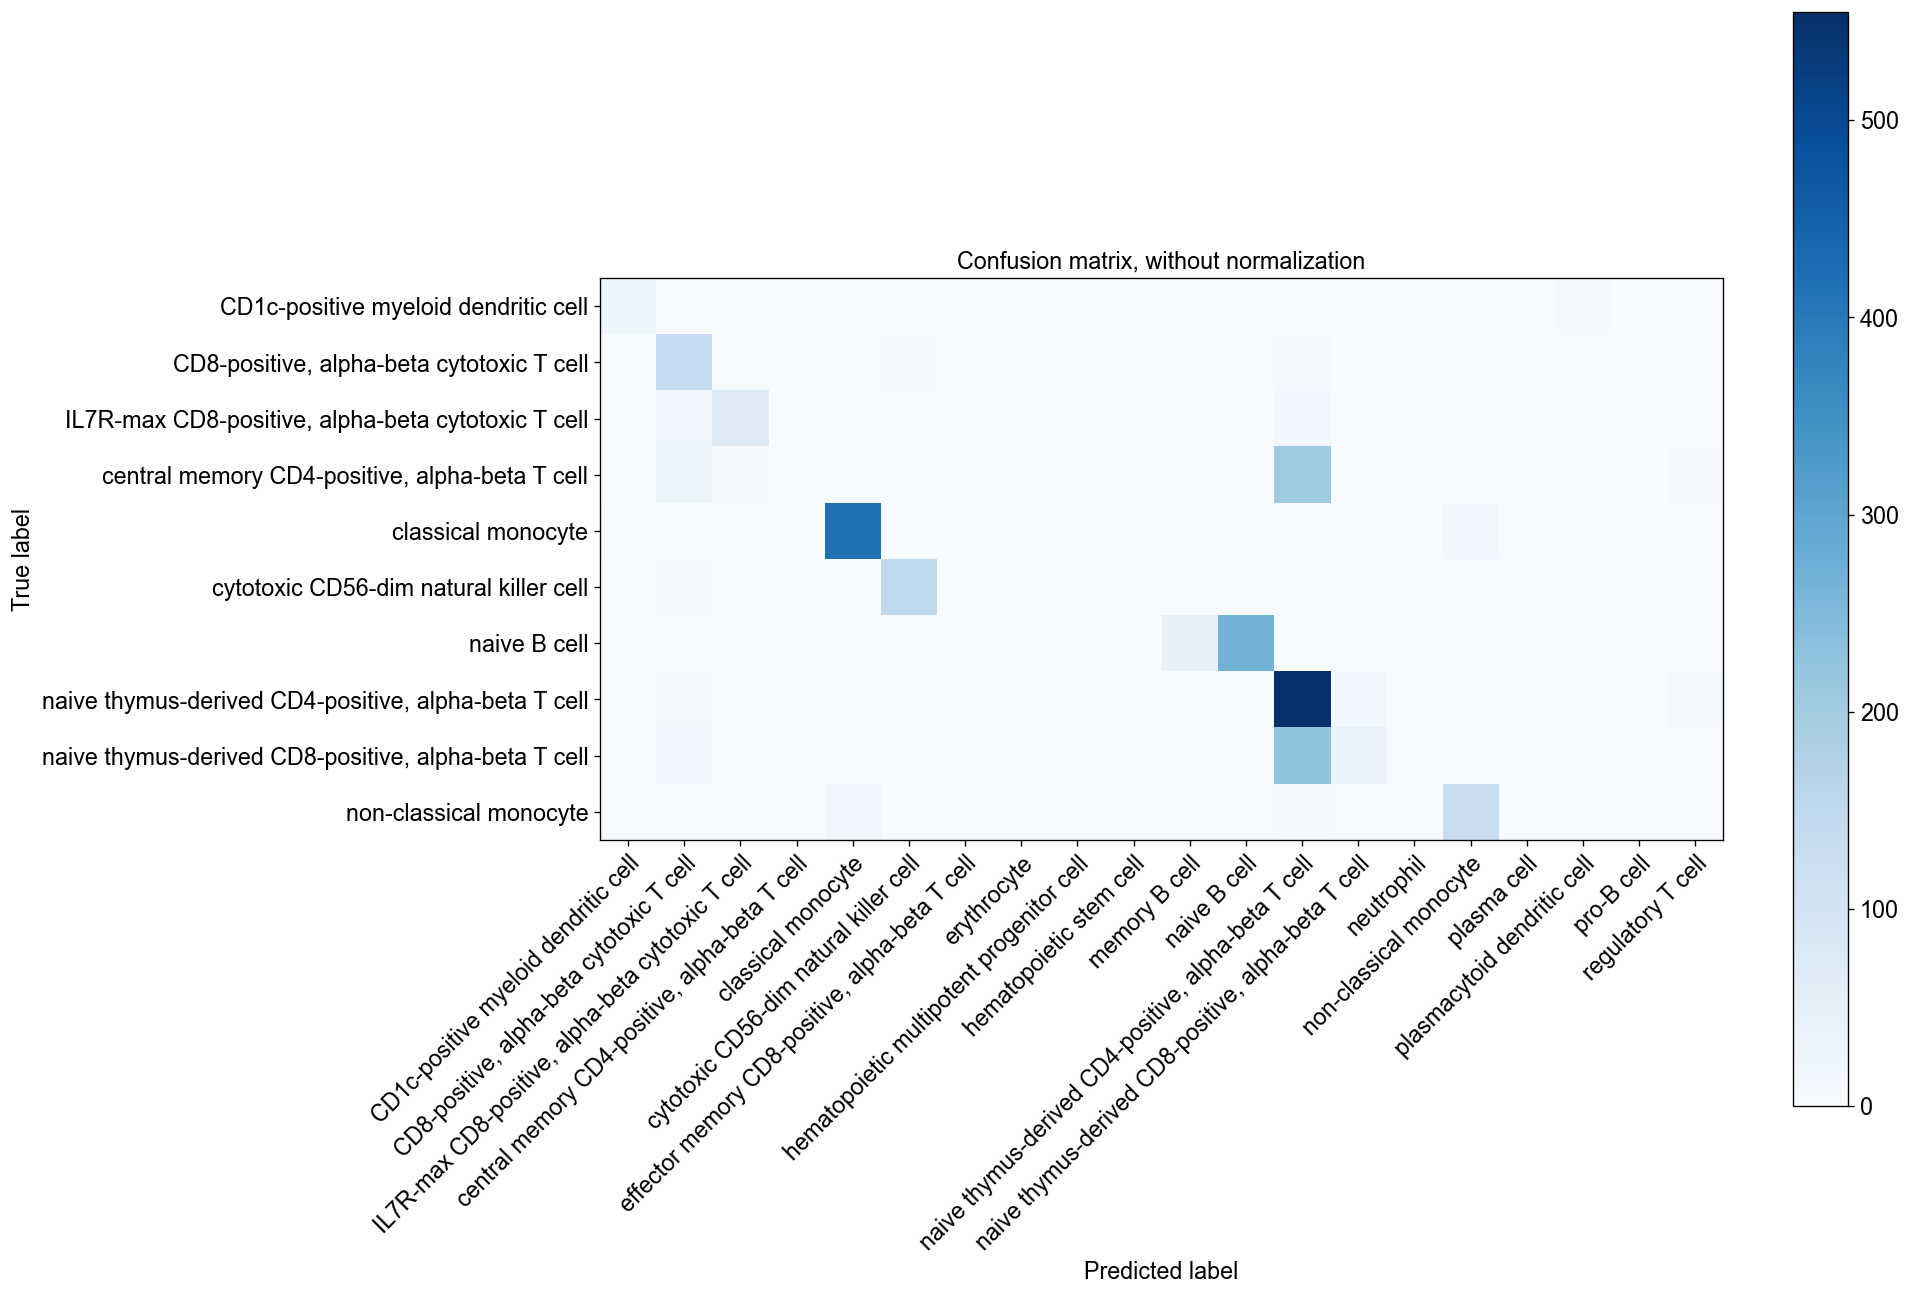

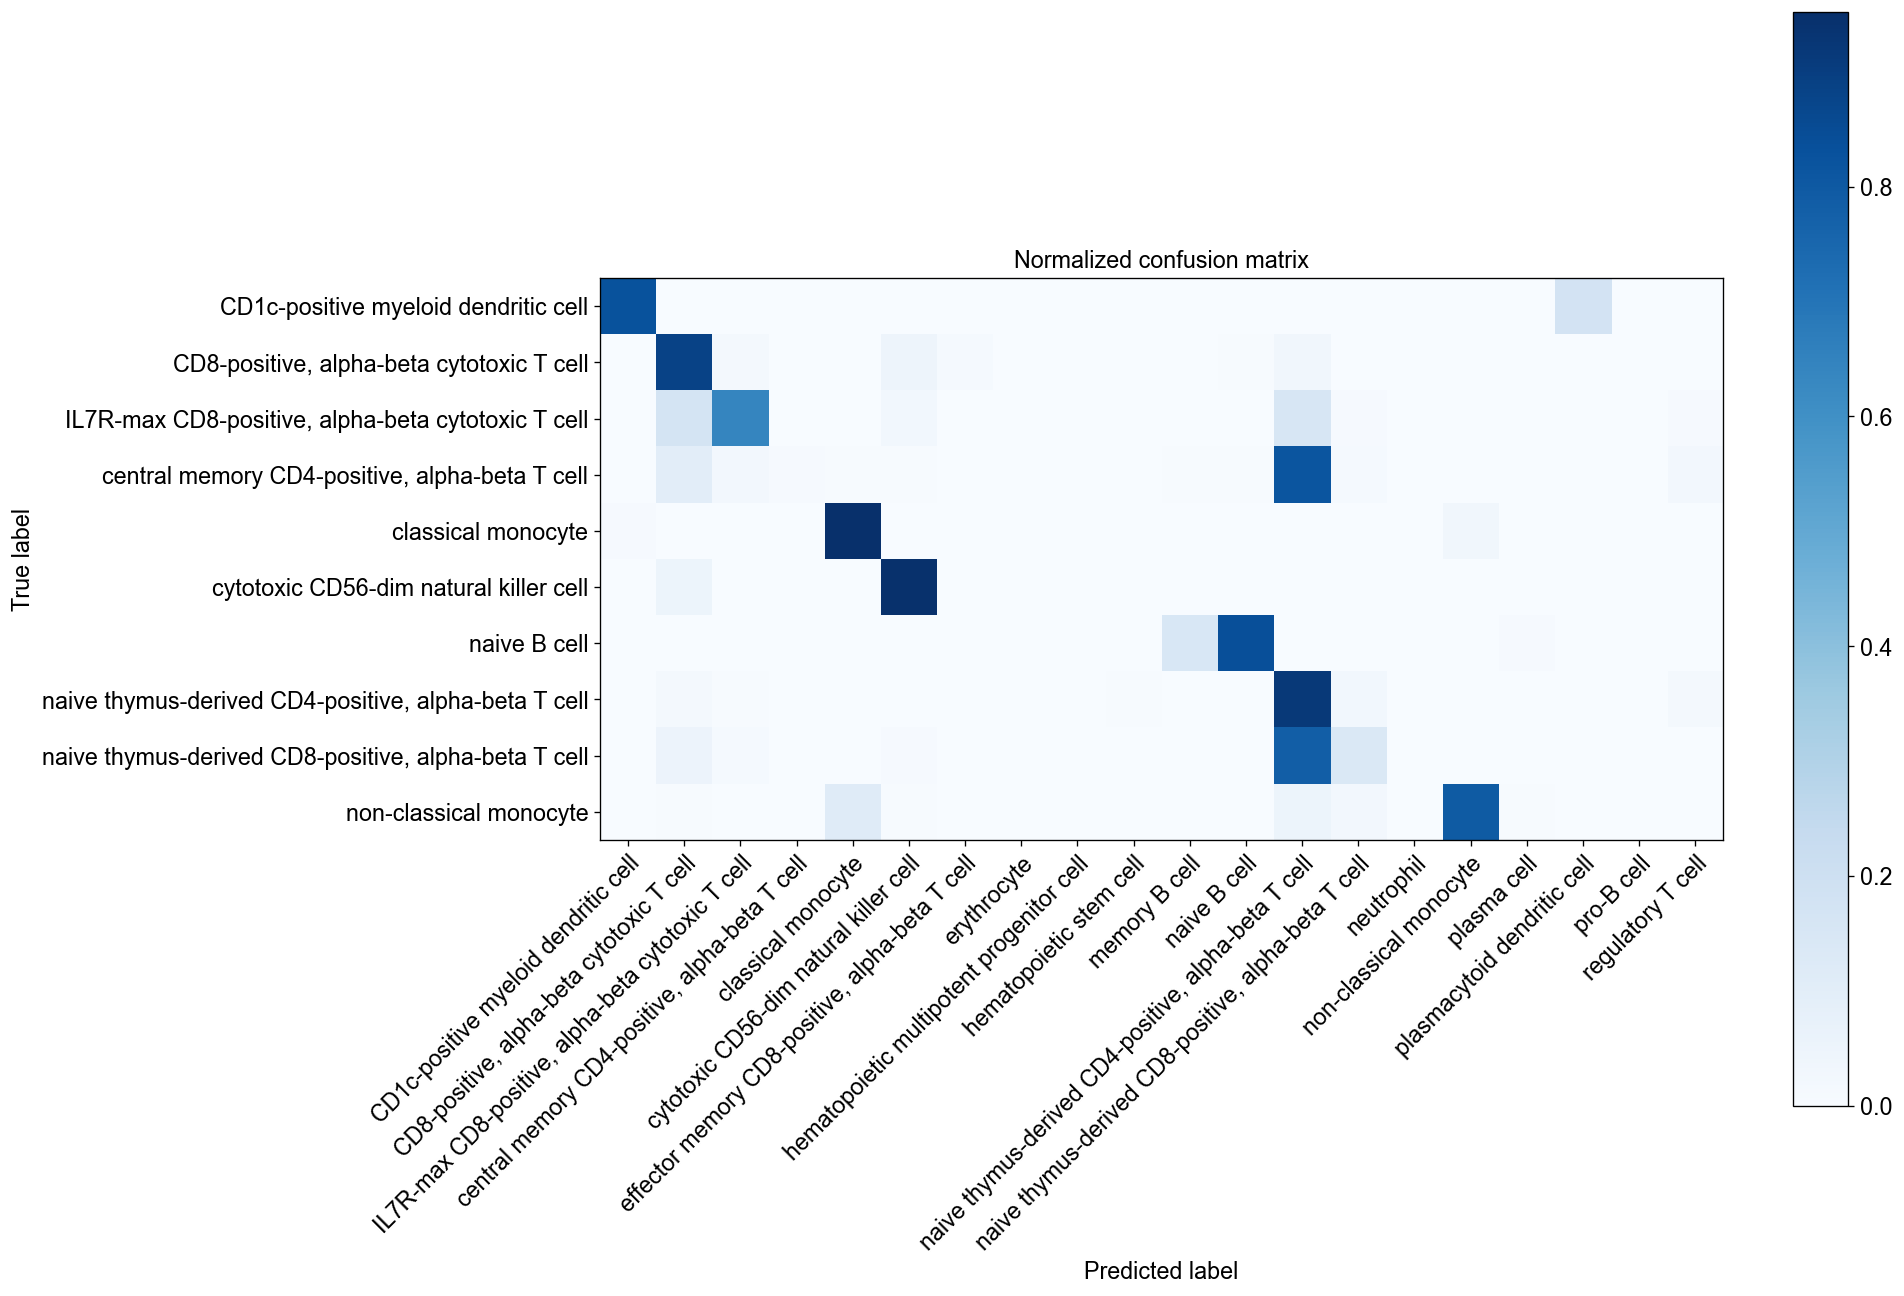

In [29]:
%matplotlib inline
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, 
                merge, use_raw, genes_to_use, clustering = 'leiden')

## Let's try with a specified gene set


Gene sets from GeMS or user specified genesets, can, if carefully chosen, significantly decrease computation time, withouth leading to a performance decrease.


In [30]:
analysis_name = "auto_annot_tutorial_geneset"
celltype = "dblabel"  # column name of celltype of interest
method = "linear"  # rbf or linear or sgd, rbf extremely slow cannot recommend, logistic_regression recommended, as you can get probabilities, random_forest is a fast but not very powerful option (in current implementation)
merge = "scanorama"
use_raw = False


In [31]:
annotSigns = bc.datasets.load_immune_signatures()
allGenes = lambda annotSigns: [item for sublist in annotSigns for item in sublist]
genes_to_use = list(set(allGenes(list(annotSigns.values()))))
display(genes_to_use[:10])


['MLANA',
 'LEF1',
 'MMRN1',
 'GZMA',
 'MCM2',
 'FGFBP2',
 'KRT18',
 'PCNA',
 'TRDC',
 'FABP4']

In [32]:
adata_test = adata_test_orig.copy()


In [33]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(
    adata_train_list, adata_test, genes_to_use=genes_to_use, merge=merge
)


merging with scanorama
using scanorama rn
Found 77 genes among all datasets
[[0.   0.69 0.52]
 [0.   0.   0.98]
 [0.   0.   0.  ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


In [34]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype)


In [35]:
adata_predicted = bc.tl.auto_annot.adata_predict(
    classifier=classifier,
    scaler=scaler,
    adata_pred=adata_test_corrected,
    adata_orig=adata_test_orig,
)


In [36]:
adata_predicted.write("/tmp/adata_predicted_svm.h5ad")


besca.tl.auto_annot.report(...) is deprecated( besca > 2.3); please use besca.tl.report(...)


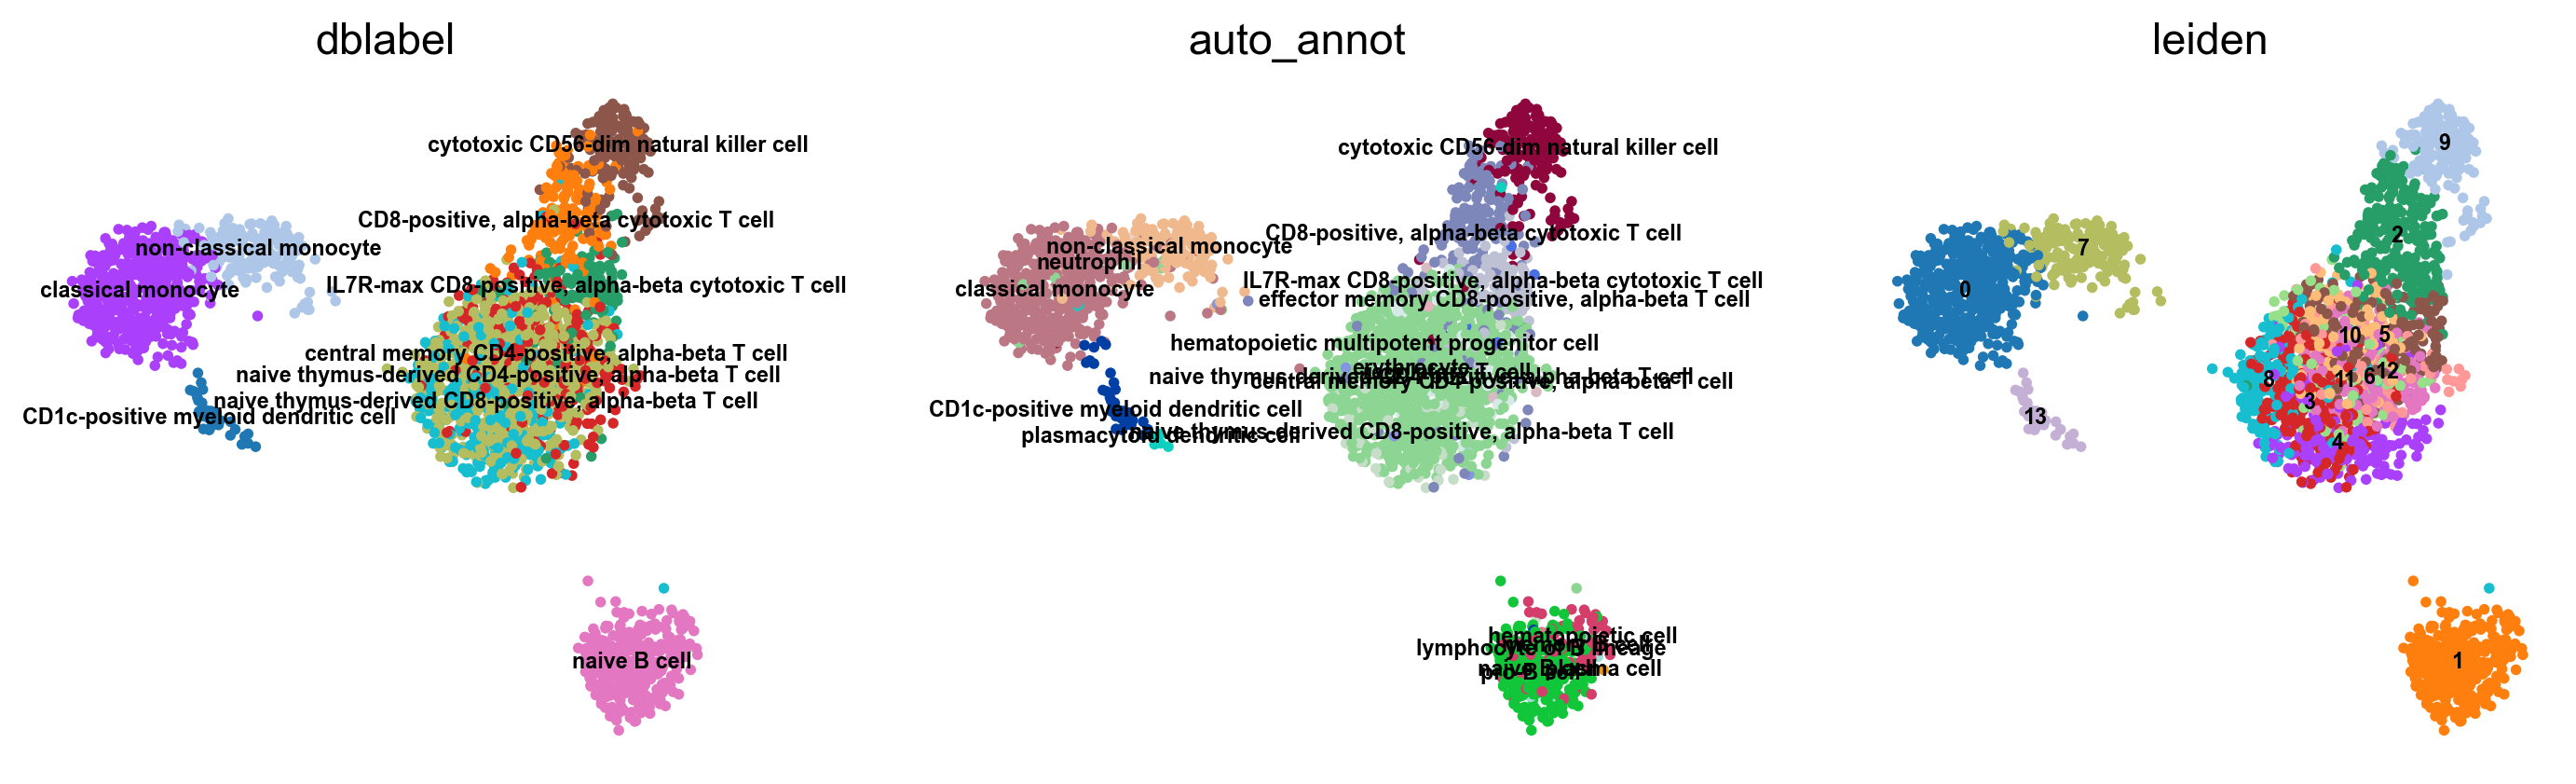

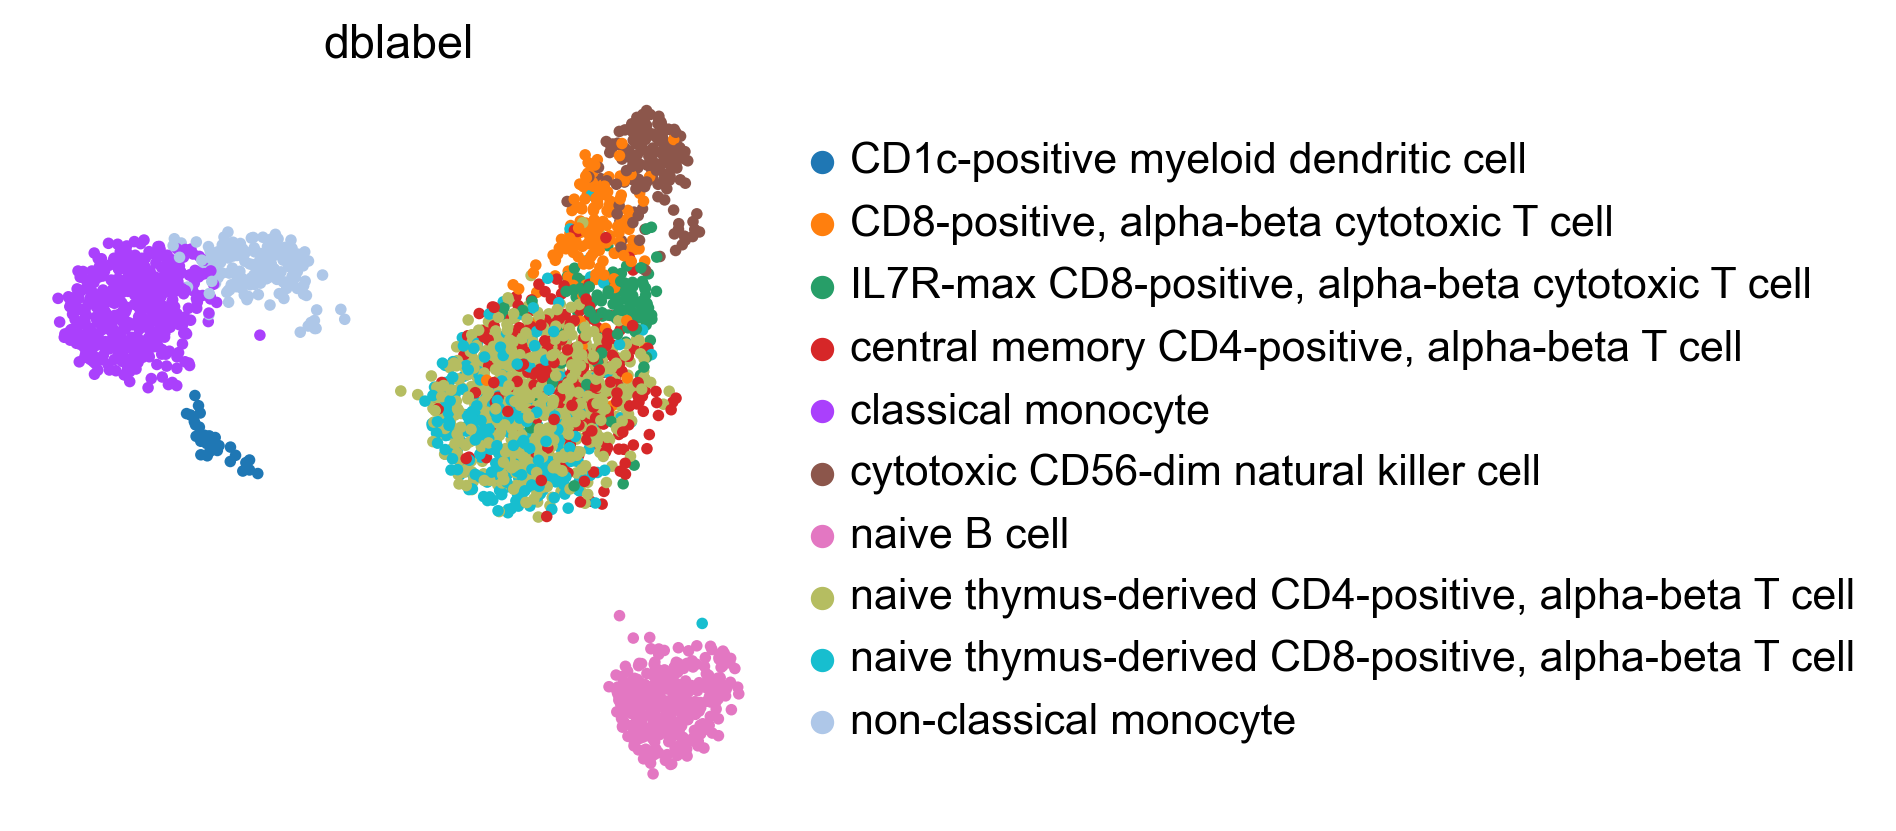

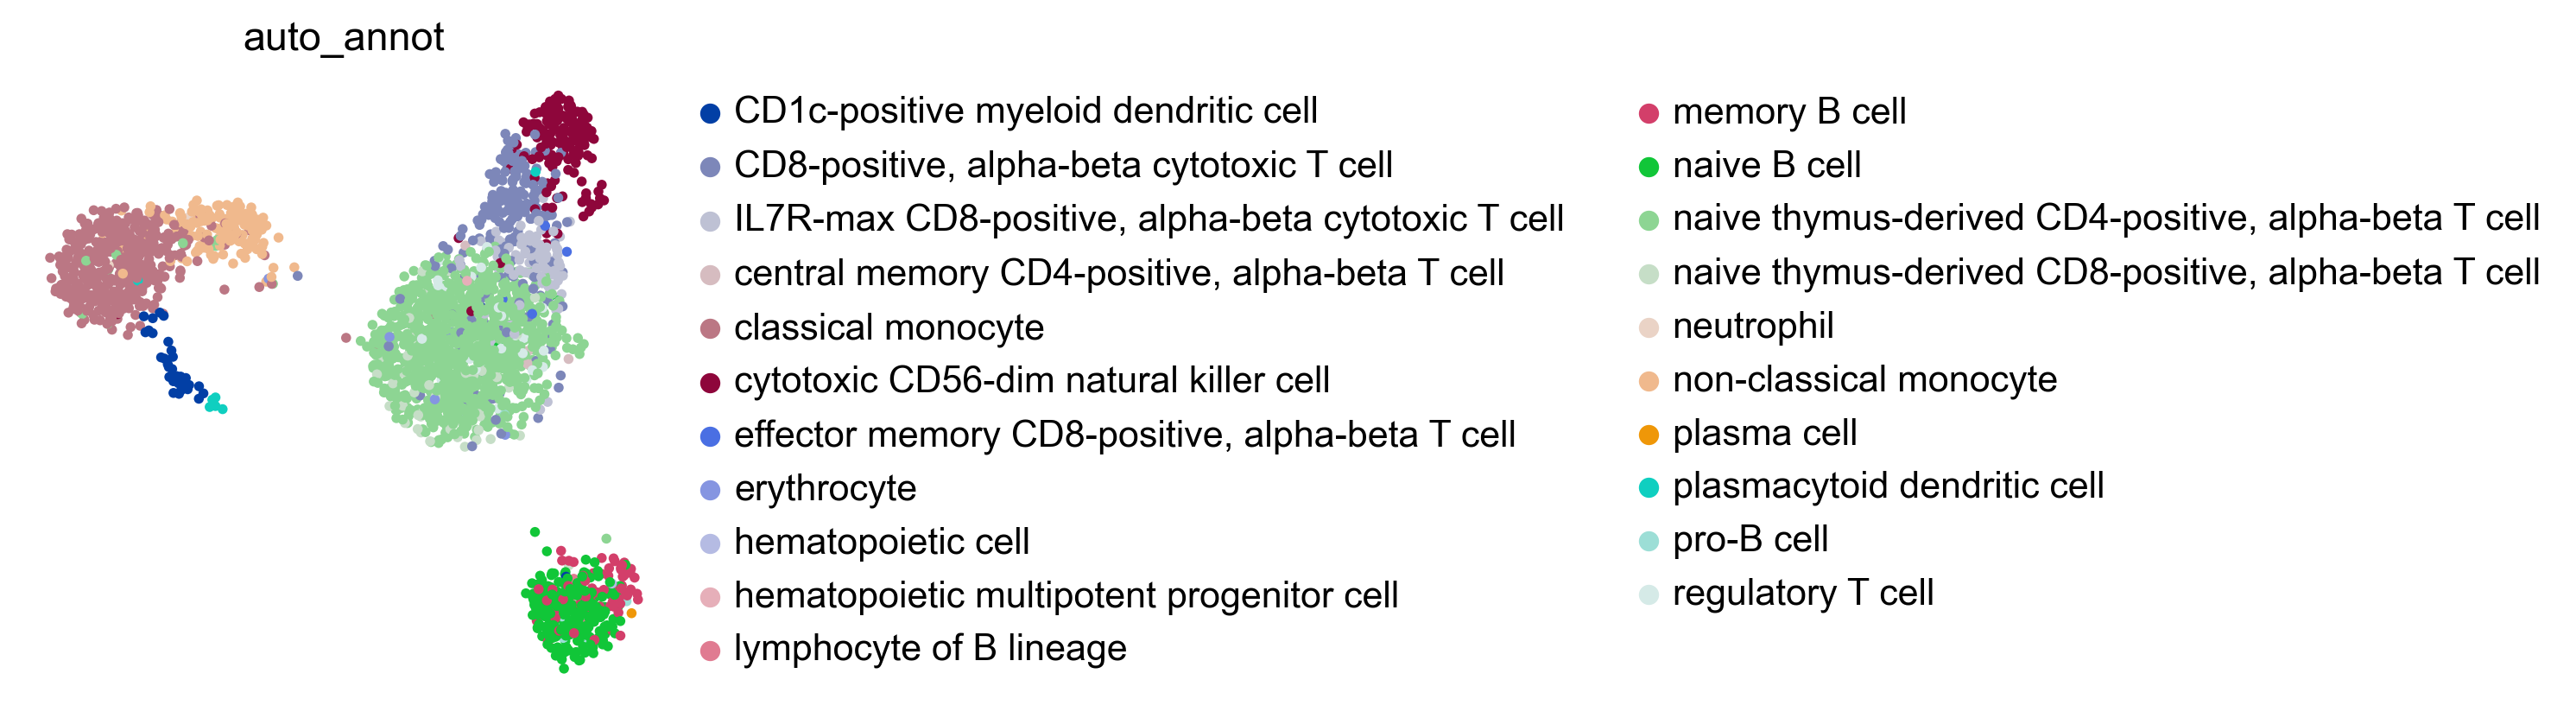

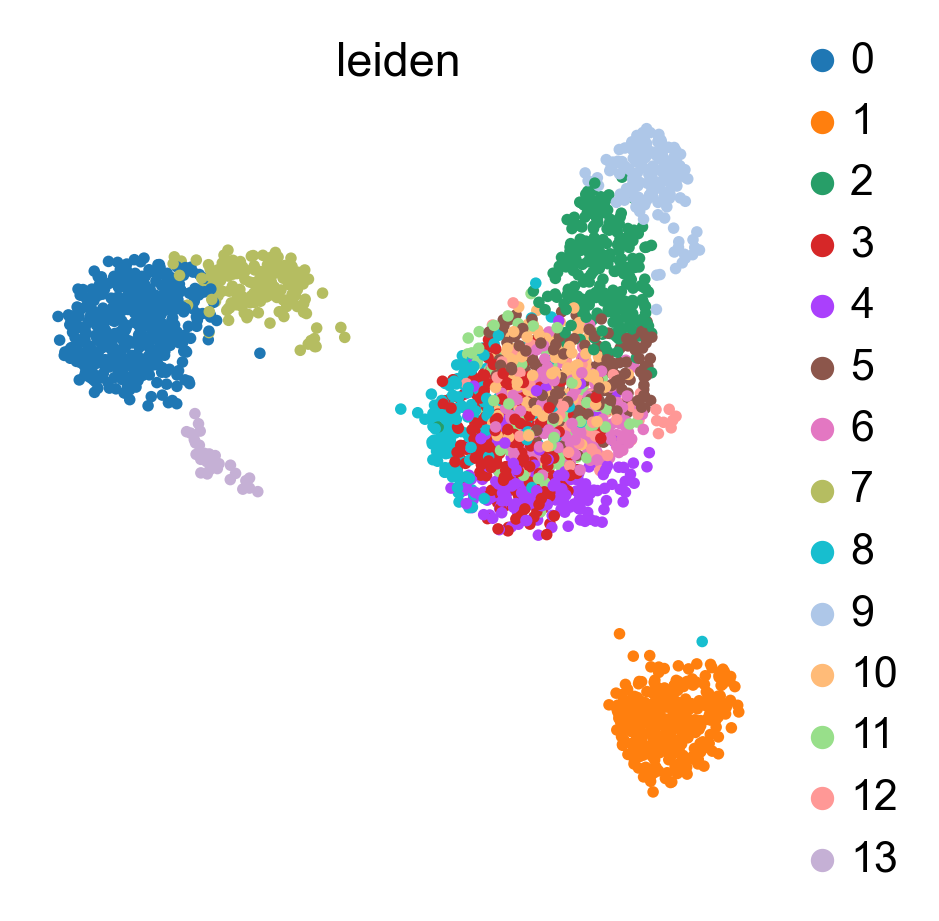

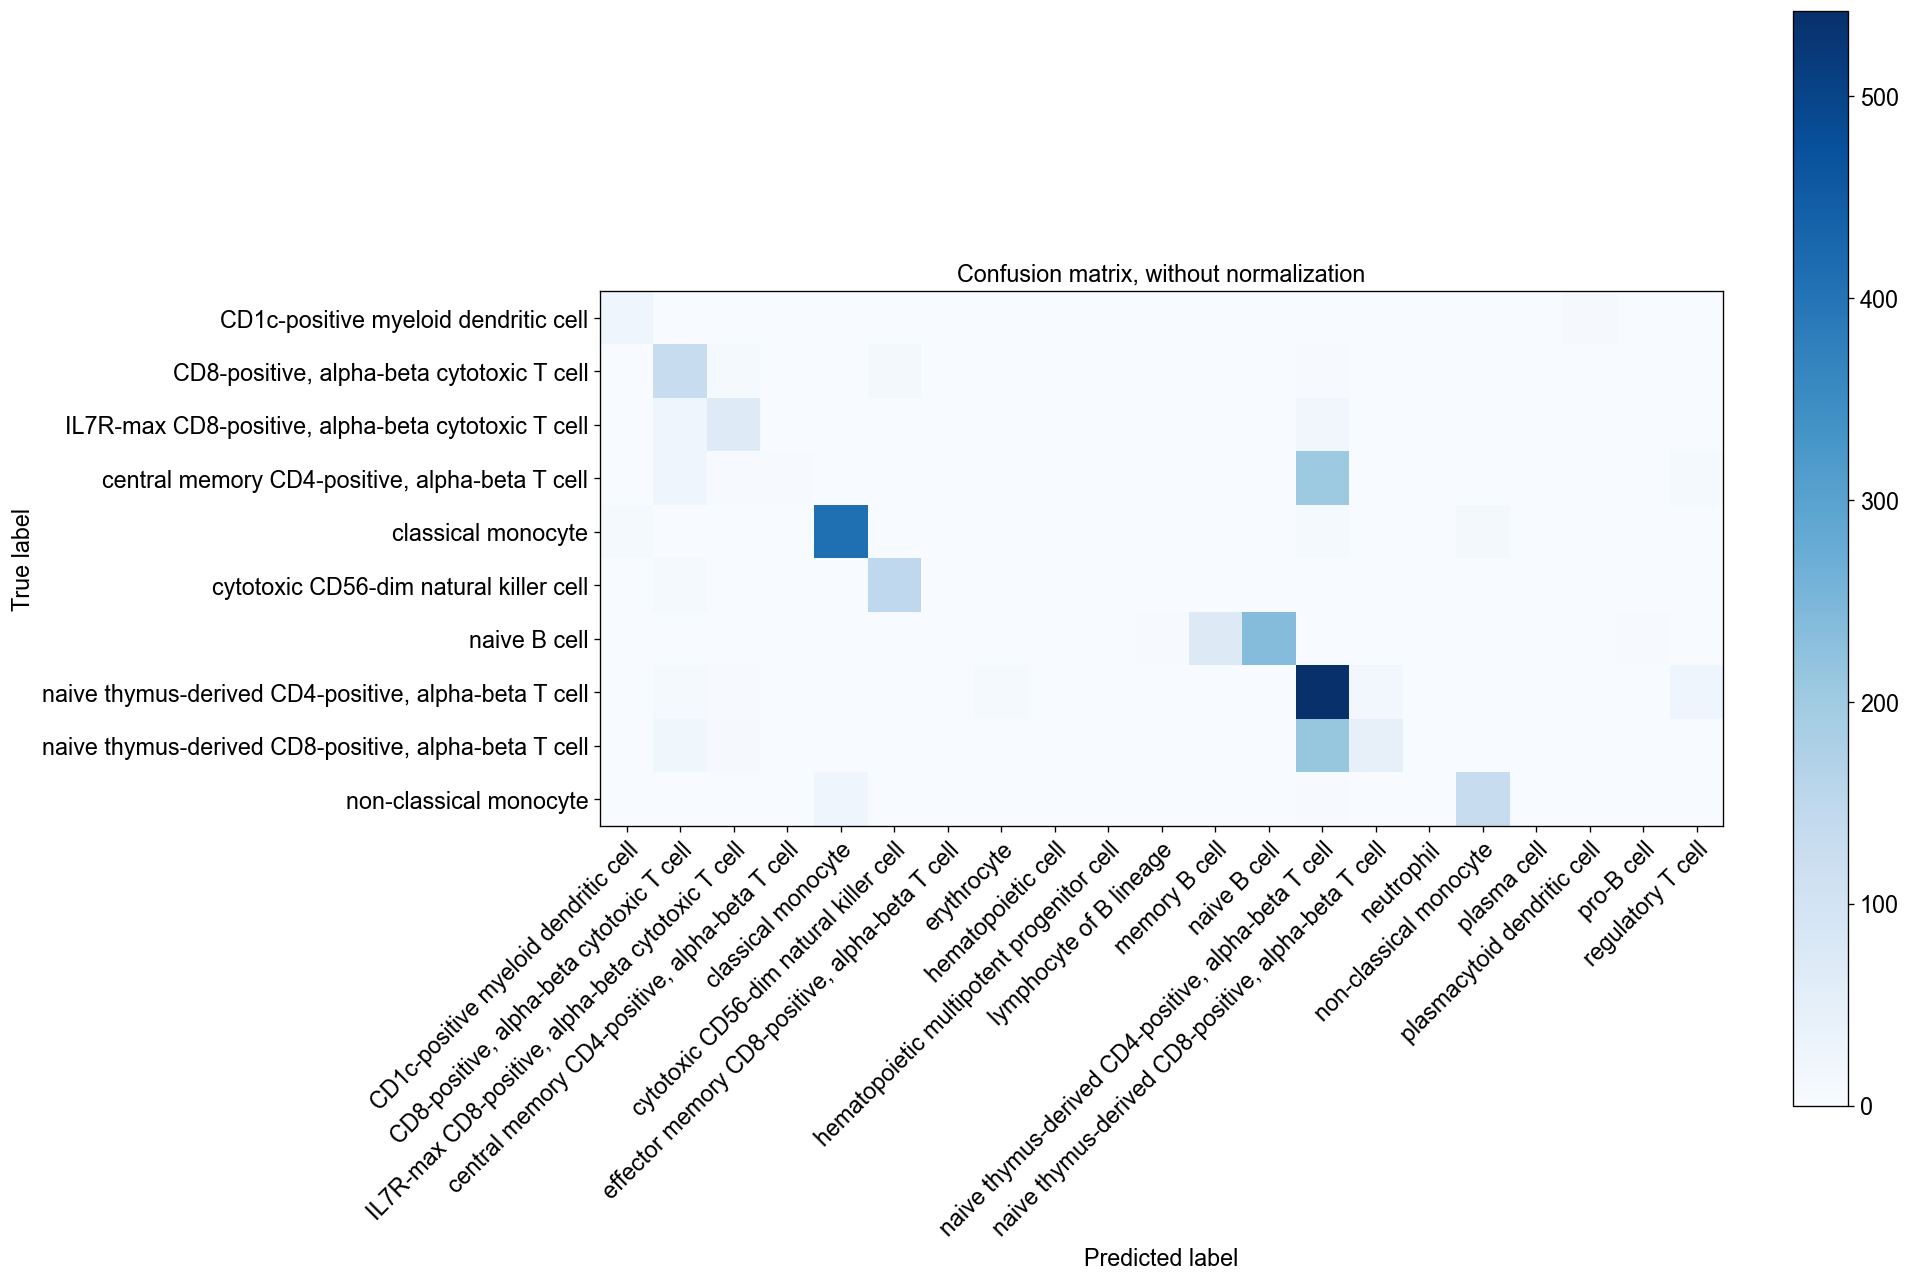

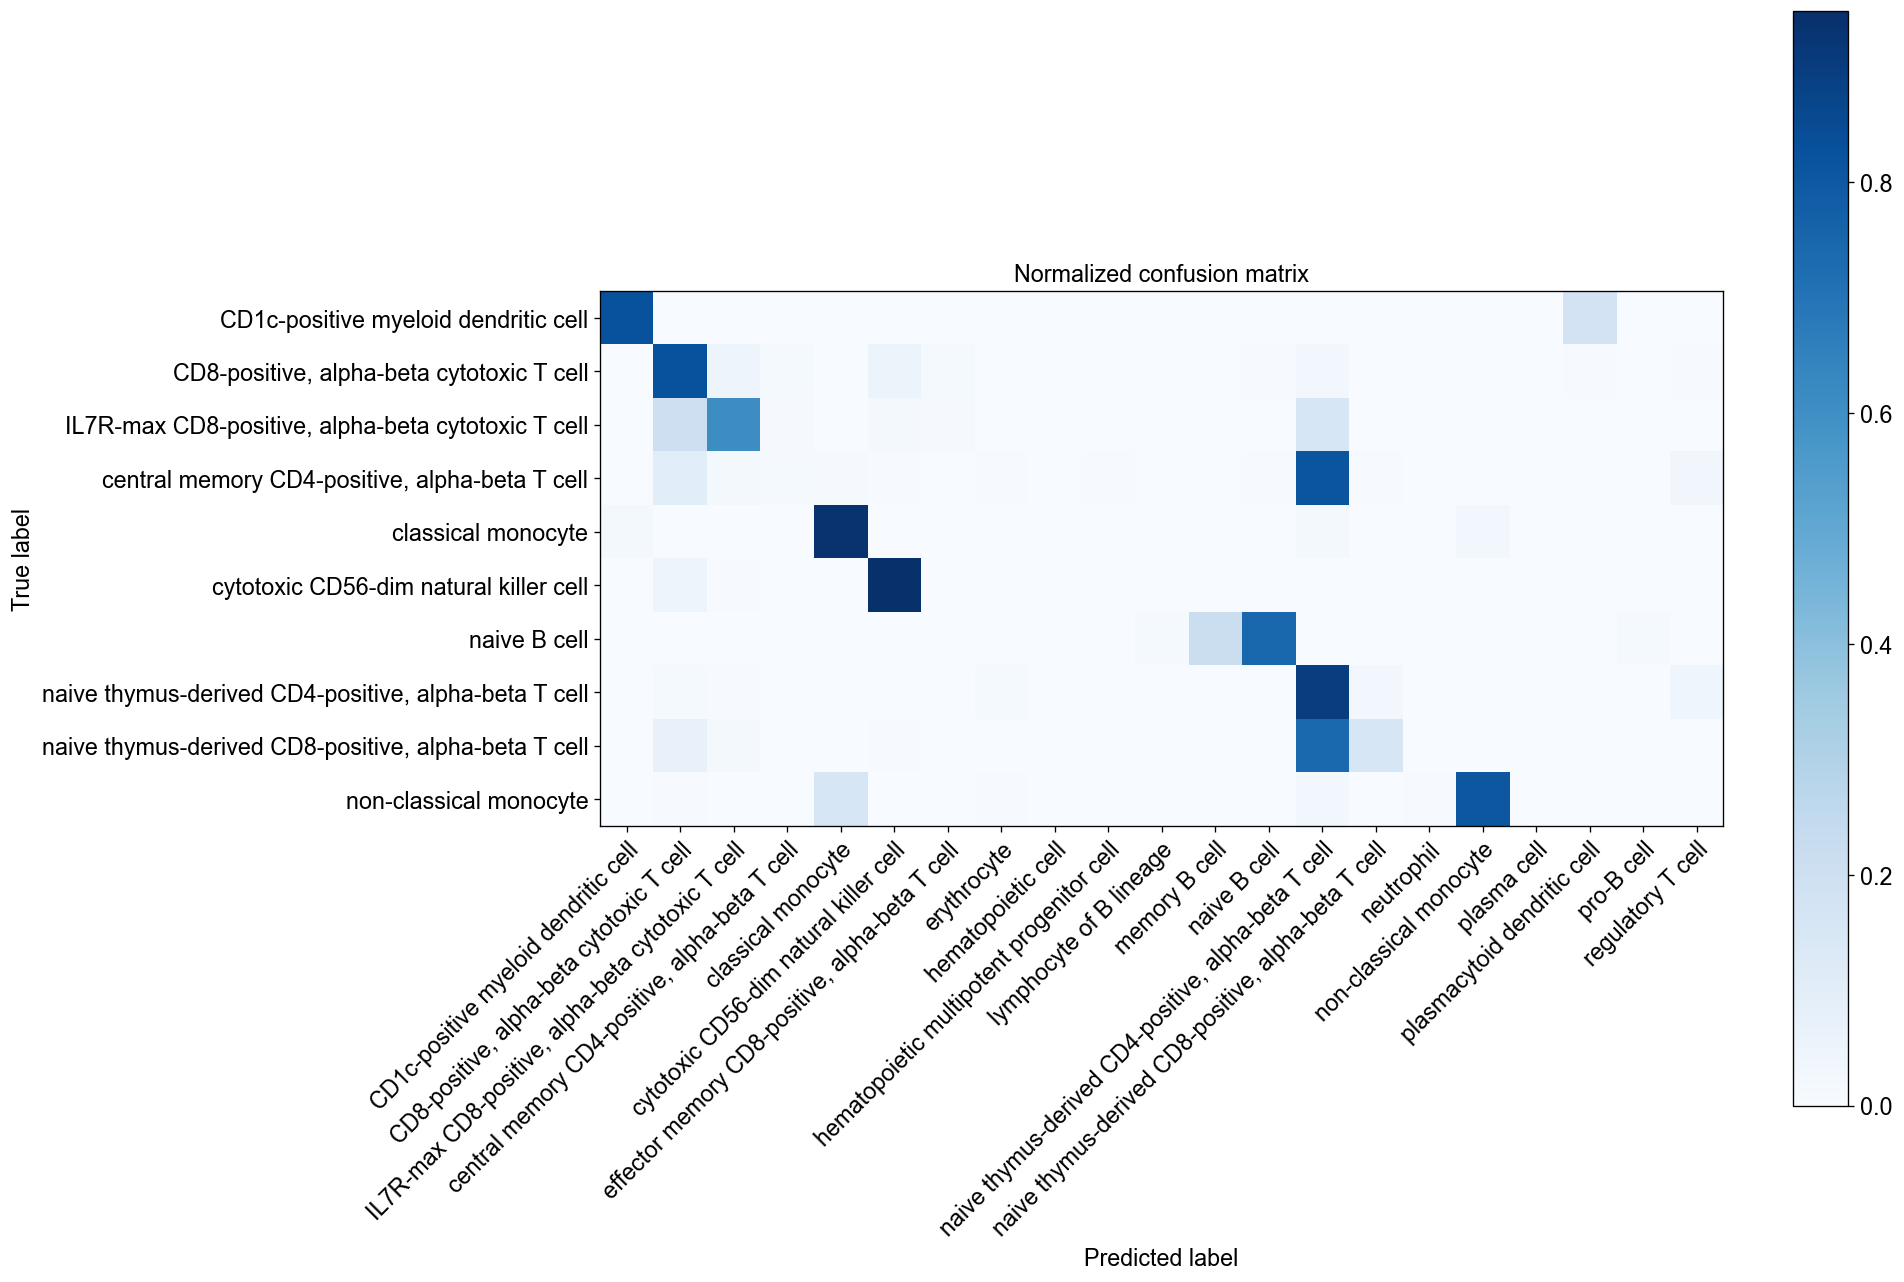

In [37]:
%matplotlib inline
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, 
False, merge, use_raw, genes_to_use, clustering = 'leiden')

## Done!
